## Load

In [1]:
%matplotlib inline

In [2]:
import os
import torch
import copy
from geom3d import train_models
from geom3d.train_models import Pymodel
from geom3d.train_models import read_config, load_data, train_val_test_split, model_setup
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Do inference tests on each model to get train/val/test for each cluster / each model

In [ ]:
import importlib
import os
from geom3d.utils import test_model_cluster_inference

importlib.reload(test_model_cluster_inference)

os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
%run /rds/general/user/cb1319/home/GEOM3D/Geom3D/src/geom3d/utils/test_model_cluster_inference.py --target 'IP' --cluster_numbers 1 2 3 4 6 --model_names 'DimeNet' 

## Get a Clean dataframe with the fragments and their clusters

In [11]:
# load config and datasets

from geom3d.utils.fragment_scaffold_split import *

from geom3d.train_models import *
import torch
import copy

from geom3d.utils import fragment_scaffold_split
from geom3d.utils import database_utils


import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/fragment_experiment/SchNet_opt_combined_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt"
dataset = torch.load(dataset_path)

threshold = 0.067

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/SchNet_opt_combined_80000


In [ ]:
# perform cluster analysis

import pandas as pd
import os

# Define the paths where the model predictions are stored
base_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/"
model_names = ['Equiformer', 'SphereNet', 'DimeNetPlusPlus']  # Add more model names if needed
num_models = len(model_names)

# Define the list of fragments
df_total, df_precursors, X_frag_mol, X_InChIKey = load_dataset(dataset, config)
fragments = X_InChIKey  # Insert your list of fragments here

# Load morgan_keys dictionary or use the function cluster_analysis(dataset, config, threshold) to obtain it
morgan_keys = cluster_analysis(dataset, config, threshold)


### Count how many oligomers contain each spec fragment

In [ ]:
fragment_oligomers = {}
morgan_keys['Oligomers'] = [None] * morgan_keys['InChIKey'].shape[0]
morgan_keys['Counts'] = [None] * morgan_keys['InChIKey'].shape[0]

for k in range(morgan_keys['InChIKey'].shape[0]):
    print(morgan_keys['InChIKey'][k])
    oligomers_count = {}
    
    # find the row in df_total that corresponds to this fragment
    for j in range(df_total.shape[0]):
        inchi_key = []
        for i in range(6):
            col_name = f'InChIKey_{i}'
            if str(df_total[col_name][j]) == str(morgan_keys['InChIKey'][k]):
                # find the InChIKey for this row in df_total
                inchi_key = df_total['InChIKey'][j]
                # add the InChIKey to the oligomers_count dictionary and update count
                oligomers_count[inchi_key] = oligomers_count.get(inchi_key, 0) + 1
    
    # convert the dictionary to lists
    oligomers = list(oligomers_count.keys())
    counts = list(oligomers_count.values())
    
    # store in fragment_oligomers dictionary
    fragment_oligomers[morgan_keys['InChIKey'][k]] = {'oligomers': oligomers, 'counts': counts}

    morgan_keys['Oligomers'][k] = oligomers
    morgan_keys['Counts'][k] = counts


In [3]:
import pandas as pd

morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

### Get the mean diff [Model] [Target] column for the dataframe, a measure of the loss associated with each frag

In [ ]:
# make a mean_diff_{model_name}_ES1 column for each model in the morgan_keys/fragment-exp-results dataframe

import pandas as pd
import os
import ast

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names
cluster_numbers = [1, 2, 3, 4, 6, 5]  # Update with your actual cluster numbers

target = 'IP'


for k in range(morgan_keys.shape[0]):
    # Get the cluster number for the current fragment
    cluster = morgan_keys['Cluster'][k]
    
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)

    # Initialize an empty list to store the mean differences for each model
    mean_diffs = []
    
    # Loop over model names
    for model_name in model_names:
        if model_name == 'DimeNet' and cluster == 5:
            continue
        else:
            print(model_name)
            # Initialize an empty list to store the differences for the current model
            diffs = []
            # Loop over oligomers, by looking at the list of oligomers for the current fragment in the morgan_keys dataframe, the list has the oligomer names separated by commas
            # for oligomer in ast.literal_eval(morgan_keys['Oligomers'][k]):
            for oligomer in morgan_keys['Oligomers'][k]:
                # Find the row in the dataframe for the current oligomer if it exists
                if oligomer not in df_cluster.index:
                    continue
                row = df_cluster.loc[oligomer]
                # Calculate the absolute difference between the true and pred columns
                diff = abs(row[model_name + f'_true_{target}'] - row[model_name + f'_pred_{target}'])
                # Append the difference to the list
                diffs.append(diff)
        
            # Calculate the mean difference for the current model
            # print(len(diffs), len(ast.literal_eval(morgan_keys['Oligomers'][k])))
            mean_diff = sum(diffs) / len(diffs)
            # Append the mean difference to the list
            mean_diffs.append(mean_diff)
    
    # Add the mean differences to the morgan_keys dataframe for the current fragment
    for i, model_name in enumerate(model_names):
        if model_name == 'DimeNet' and cluster == 5:
            continue
        else:
            col_name = f'mean_diff_{model_name}_{target}'
            if col_name not in morgan_keys.columns:
                morgan_keys[col_name] = None  # Create the column if it doesn't exist
            
            # Assign the mean differences to the corresponding column and row
            morgan_keys.loc[k, col_name] = mean_diffs[i]




### Get the mean diff [Model] [Target] column for the dataframe, a measure of the loss associated with each frag

In [ ]:
# make a mean_diff_{model_name}_ES1 column for each model in the morgan_keys/fragment-exp-results dataframe weighted

import pandas as pd
import os
import ast

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names
cluster_numbers = [1, 2, 3, 4, 6, 5]  # Update with your actual cluster numbers

target = 'ES1'

for k in range(morgan_keys.shape[0]):
    # Get the cluster number for the current fragment
    cluster = morgan_keys['Cluster'][k]
    
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)

    # Initialize an empty list to store the mean differences for each model
    mean_diffs = []
    
    # Loop over model names
    for model_name in model_names:
        if model_name == 'DimeNet' and cluster == 5:
            continue
        else:
            print(model_name)
            # Initialize an empty list to store the differences for the current model
            diffs = []
            # Loop over oligomers, by looking at the list of oligomers for the current fragment in the morgan_keys dataframe, the list has the oligomer names separated by commas
            # for oligomer in ast.literal_eval(morgan_keys['Oligomers'][k]):
            for oligomer in morgan_keys['Oligomers'][k]:
                # Find the row in the dataframe for the current oligomer if it exists
                if oligomer not in df_cluster.index:
                    continue
                row = df_cluster.loc[oligomer]
                # Calculate the absolute difference between the true and pred columns
                diff = abs(row[model_name + f'_true_{target}'] - row[model_name + f'_pred_{target}'])
                # look at the corresponding count for the oligomer and append it to diffs that many times
                count = morgan_keys['Counts'][k][morgan_keys['Oligomers'][k].index(oligomer)]
                for i in range(count):
                    diffs.append(diff)
        
            # Calculate the mean difference for the current model
            print(len(diffs), len(morgan_keys['Oligomers'][k]))
            mean_diff = sum(diffs) / len(diffs)
            # Append the mean difference to the list
            mean_diffs.append(mean_diff)
    
    # Add the mean differences to the morgan_keys dataframe for the current fragment
    for i, model_name in enumerate(model_names):
        if model_name == 'DimeNet' and cluster == 5:
            continue
        else:
            col_name = f'mean_diff_{model_name}_{target}_weighted'
            if col_name not in morgan_keys.columns:
                morgan_keys[col_name] = None  # Create the column if it doesn't exist
            
            # Assign the mean differences to the corresponding column and row
            morgan_keys.loc[k, col_name] = mean_diffs[i]




In [35]:
# save the morgan_keys dataframe
morgan_keys.to_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

In [34]:
# in the mean_diff_DimeNetPlusPlus_ES1 column, set wanted rows to NaN
morgan_keys.loc[morgan_keys['Cluster'] == 5, 'mean_diff_DimeNet_ES1_weighted'] = np.nan


In [36]:
# view which values are NaN
morgan_keys.isna().sum()

InChIKey                                     0
Morgan_Fingerprint                           0
Cluster                                      0
Oligomers                                    0
Counts                                       0
mean_diff_SchNet_ES1                         0
mean_diff_PaiNN_ES1                          0
mean_diff_Equiformer_ES1                     0
mean_diff_SphereNet_ES1                      0
mean_diff_DimeNetPlusPlus_ES1                0
mean_diff_DimeNet_ES1                       60
smiles                                       0
X_frag_mol                                   0
mean_diff_average_ES1                        0
mean_diff_SchNet_fosc1                       0
mean_diff_PaiNN_fosc1                        0
mean_diff_Equiformer_fosc1                   0
mean_diff_SphereNet_fosc1                    0
mean_diff_DimeNetPlusPlus_fosc1              0
mean_diff_DimeNet_fosc1                     60
mean_diff_average_fosc1                      0
mean_diff_Sch

In [37]:
%matplotlib inline

### Get PCA plot with each fragment and its associated loss

/var/tmp/pbs.9137156.pbs/ipykernel_1466067/3809819373.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('summer')


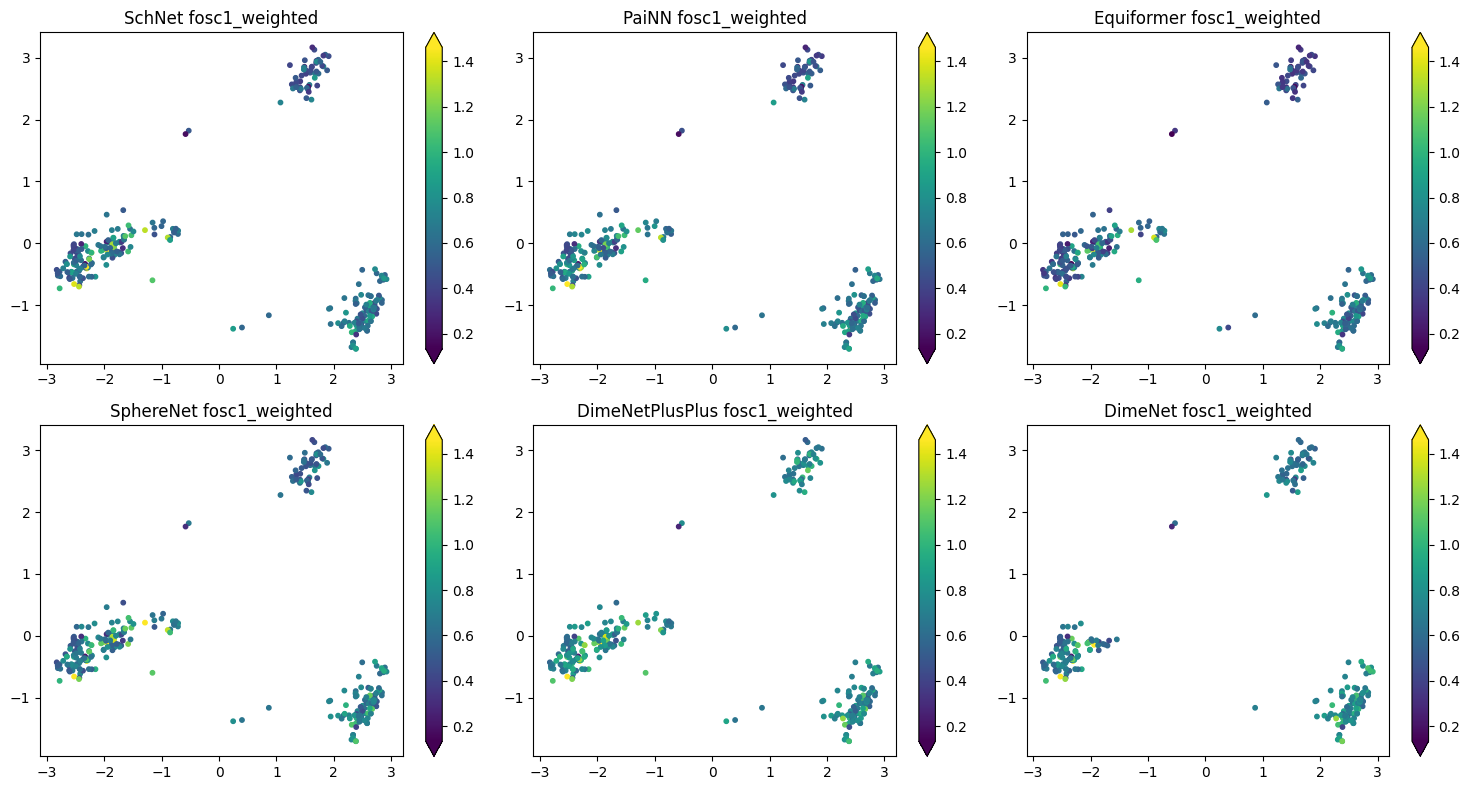

In [87]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

target = 'fosc1'
weight = '_weighted'

morgan_fingerprints = np.array(morgan_keys['Morgan_Fingerprint'].to_list())

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(morgan_fingerprints)

# Calculate the overall minimum and maximum values for color bar limits
min_val = min([morgan_keys[f'mean_diff_{model_name}_{target}{weight}'].min() for model_name in model_names])
max_val = min([morgan_keys[f'mean_diff_{model_name}_{target}{weight}'].max() for model_name in model_names]) - 1

# Create a scatter plot for each model
num_models = len(model_names)
num_cols = num_models // 2 + num_models % 2  
fig, axs = plt.subplots(2, num_cols, figsize=(15, 8))  

for i, model_name in enumerate(model_names):
    row = i // num_cols
    col = i % num_cols
    
    # Scatter plot
    scatter = axs[row, col].scatter(pca_result[:, 0], pca_result[:, 1], c=morgan_keys[f'mean_diff_{model_name}_{target}{weight}'], cmap='viridis', s=10, alpha=1, vmin=min_val, vmax=max_val)
    
    # Set NaN values to grey
    cmap = plt.cm.get_cmap('summer')
    cmap.set_bad(color='grey')
    
    # Add a color bar using the overall minimum and maximum values
    cbar = plt.colorbar(scatter, ax=axs[row, col], extend='both')
    cbar.ax.tick_params(labelsize=10)

    # Set the title
    axs[row, col].set_title(model_name + f' {target}{weight}')

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()


## Plot the various clusters on PCA by color

In [38]:
from geom3d.train_models import *
import torch
import copy

from geom3d.utils import fragment_scaffold_split
from geom3d.utils import database_utils


import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/fragment_experiment/SchNet_opt_combined_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt"
dataset = torch.load(dataset_path)

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/SchNet_opt_combined_80000


clustering done with metric: rogerstanimoto
Index(['InChIKey', 'Morgan_Fingerprint'], dtype='object')
Clustering dataset with threshold 0.067
Number of clusters: 10
Number of molecules in each cluster for morgan fp: {1: 99, 2: 51, 3: 7, 4: 29, 5: 27, 6: 3, 7: 60, 8: 19, 9: 8, 10: 7}
Number of molecules in each cluster after merging small clusters: {1: 99, 2: 51, 3: 36, 4: 30, 5: 60, 6: 34}


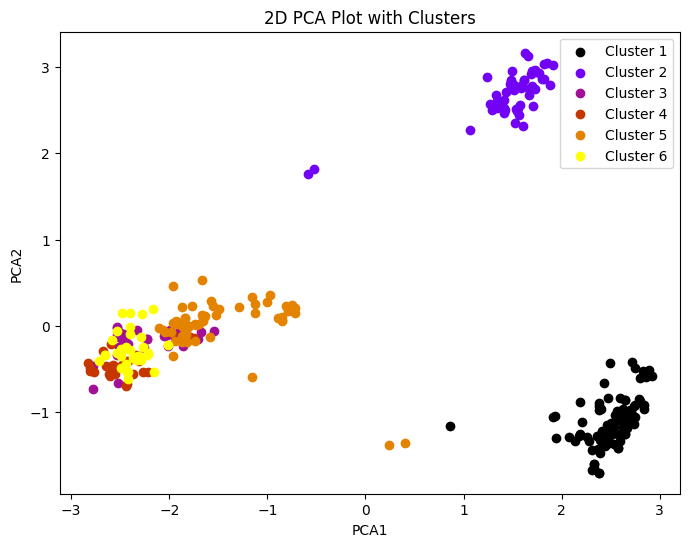

In [68]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

pca_plot(dataset, config, threshold = 0.067)

## Explore Biases

### Std error depending on the cluster for each model

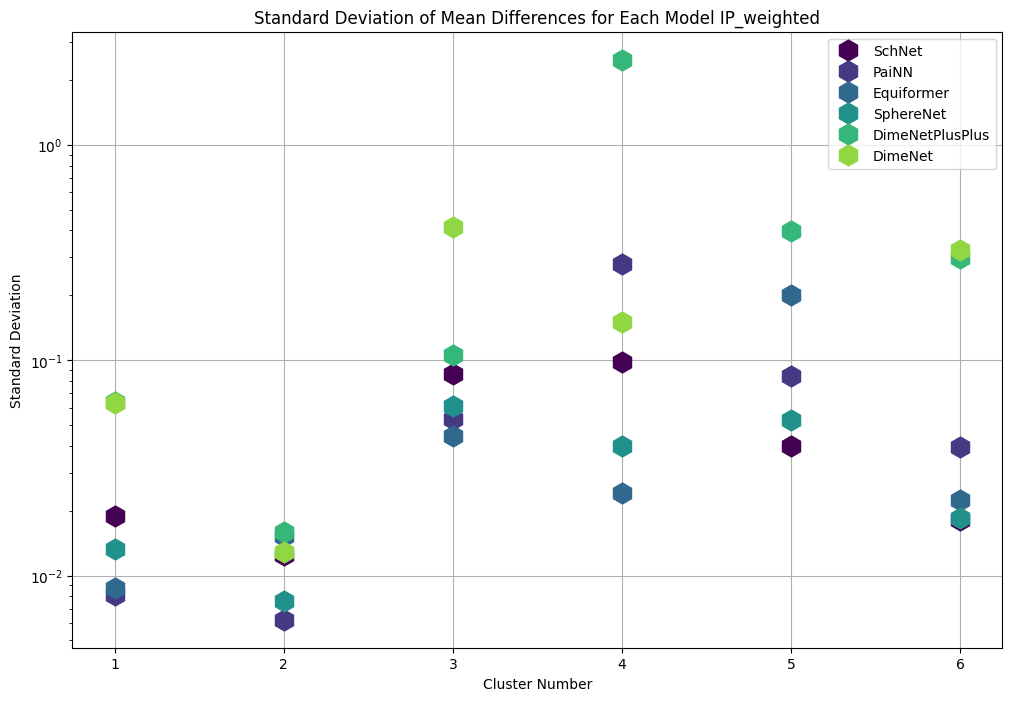

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] 
cluster_numbers = [1, 2, 3, 4, 5, 6]  

target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Initialize a dictionary to store the standard deviations for each model and cluster
std_devs = {}

# Loop over model names
for model_name in model_names:
    # Initialize an empty list to store standard deviations for the current model
    std_devs[model_name] = []
    
    # Loop over cluster numbers
    for cluster in cluster_numbers:
        # Find the rows in the morgan_keys dataframe that correspond to the current cluster
        cluster_df = morgan_keys[morgan_keys['Cluster'] == cluster]
        
        # Calculate the standard deviation for the current model and cluster
        std_dev = cluster_df[f'mean_diff_{model_name}_{target}{weight}'].std()
        
        # Append the standard deviation to the list
        std_devs[model_name].append(std_dev)

# Create a figure
plt.figure(figsize=(12, 8))

# Get the number of models
num_models = len(model_names)

# Define the colormap
colormap = viridis

# Loop over model names
for i, model_name in enumerate(model_names):
    # Calculate the color for the current model
    color = colormap(i / num_models)
    # Plot the standard deviations for the current model
    plt.plot(cluster_numbers, std_devs[model_name], marker='h', label=model_name, color=color, linestyle='', markersize=15)

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Standard Deviation')
plt.title(f'Standard Deviation of Mean Differences for Each Model {target}{weight}')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.show()


### Plots of the differences between true and pred for each cluster over all models, and also how much the amt of oligomers affects the data

/var/tmp/pbs.9137156.pbs/ipykernel_1466067/1637079030.py:36: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}{weight}'])


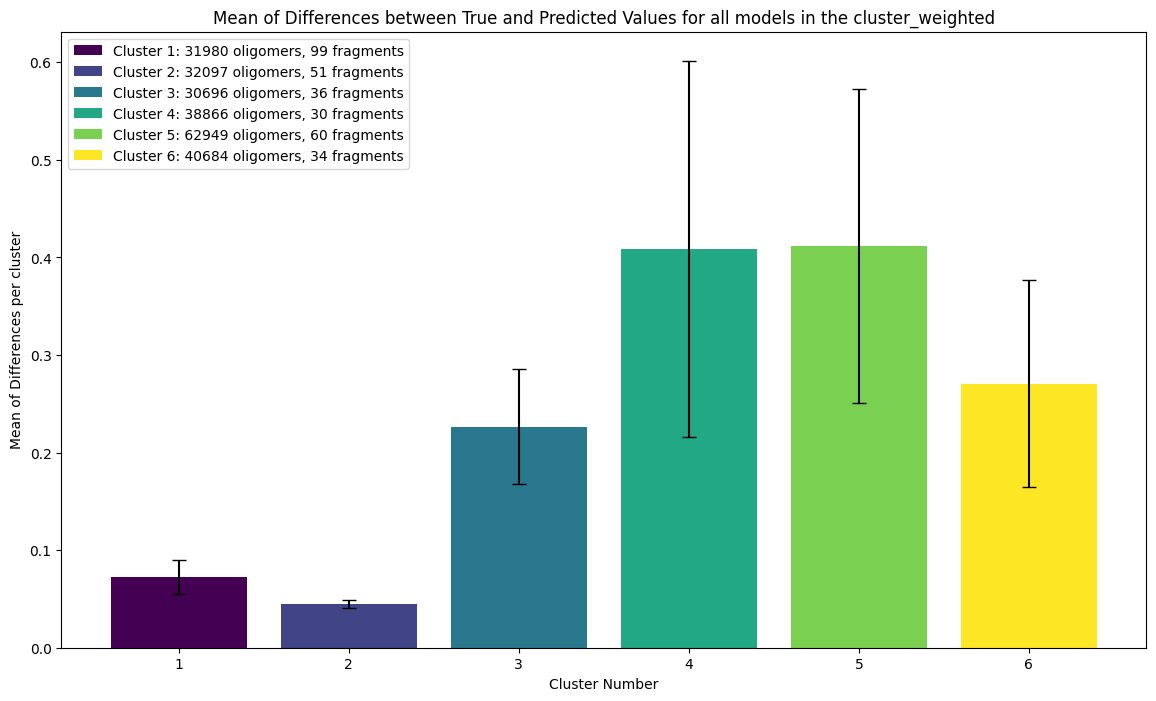

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


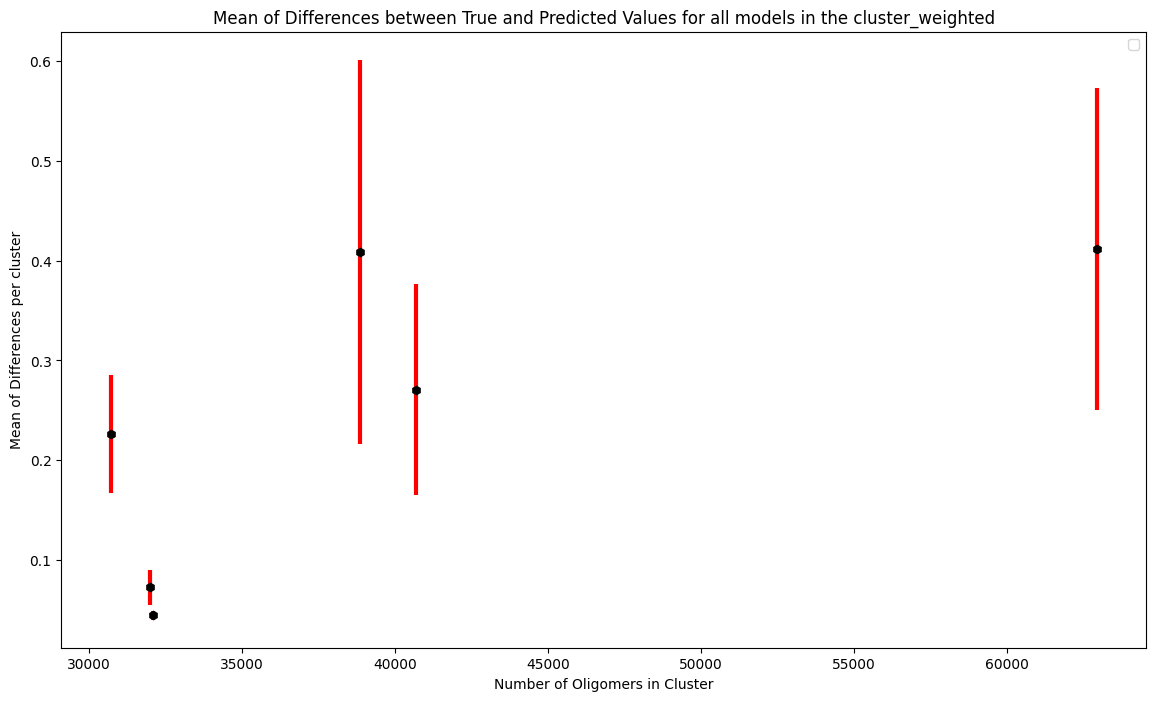

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis
import os

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] 
cluster_numbers = [1, 2, 3, 4, 5, 6]  

target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Initialize lists to store means and standard errors for each cluster
means = []
std_errors = []
length = []
length_frag = []

# Create a colormap
colors = viridis(np.linspace(0, 1, len(cluster_numbers)))

# Loop over cluster numbers
for cluster in cluster_numbers:
    # Filter morgan_keys DataFrame by the current cluster
    cluster_morgan_keys = morgan_keys[morgan_keys['Cluster'] == cluster]
    
    # Initialize an empty list to store the means for the current cluster
    cluster_mean_diffs = []
    
    # Loop over model names
    for model_name in model_names:
        # Calculate the mean of the mean_diff_{model}_ES1 column for the current cluster
        mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}{weight}'])
        
        # Append the mean to the list
        cluster_mean_diffs.append(mean_diff)
    
    # Calculate the mean and standard error for the current cluster
    cluster_mean = np.nanmean(cluster_mean_diffs)
    cluster_std_error = np.nanstd(cluster_mean_diffs) / np.sqrt(len(cluster_mean_diffs))
    
    # Append to the lists
    means.append(cluster_mean)
    std_errors.append(cluster_std_error)

    # load the csv file for the cluster
    csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv'
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)

    # add the length of the cluster to the length list for each cluster
    length.append(len(df))

    # print how many fragments are in each cluster by looking at morgan_keys dataframe
    length_frag.append(len(cluster_morgan_keys))

# Create a bar plot with error bars
plt.figure(figsize=(14, 8))
plt.bar(cluster_numbers, means, yerr=std_errors, capsize=5, color=colors, label=[f'Cluster {cluster}: {length[i]} oligomers, {length_frag[i]} fragments' for i, cluster in enumerate(cluster_numbers)])

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Mean of Differences per cluster')
plt.title(f'Mean of Differences between True and Predicted Values for all models in the cluster{weight}')

plt.legend()
plt.show()

# make a plot showing the number of oligomers in each cluster vs the mean of differences per cluster
plt.figure(figsize=(14, 8))
# add the std_error to the plot
plt.errorbar(length, means, yerr=std_errors, fmt='h', color='black', ecolor='red', elinewidth=3, capsize=0)

# Add labels and title
plt.xlabel('Number of Oligomers in Cluster')
plt.ylabel('Mean of Differences per cluster')
plt.title(f'Mean of Differences between True and Predicted Values for all models in the cluster{weight}')

plt.legend()
plt.show()

### Difference between true and pred for each model, which is the most performant?

In [5]:
%matplotlib inline

/var/tmp/pbs.9216454.pbs/ipykernel_2622970/2868364529.py:39: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}{weight}'])


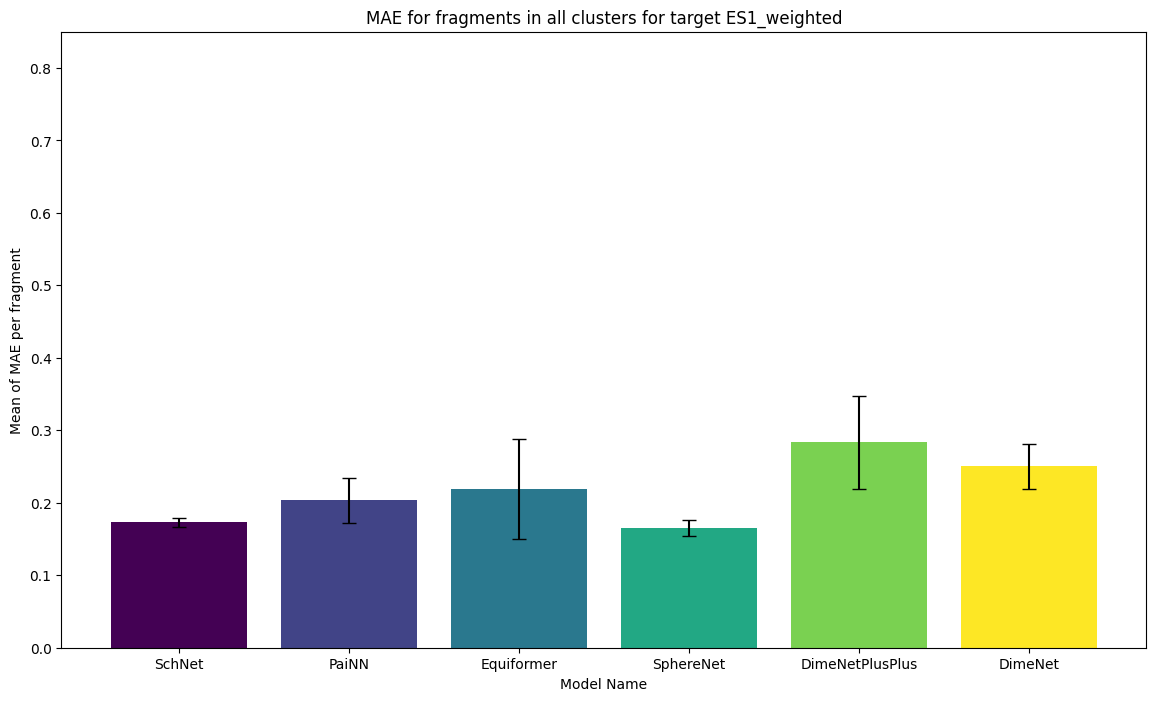

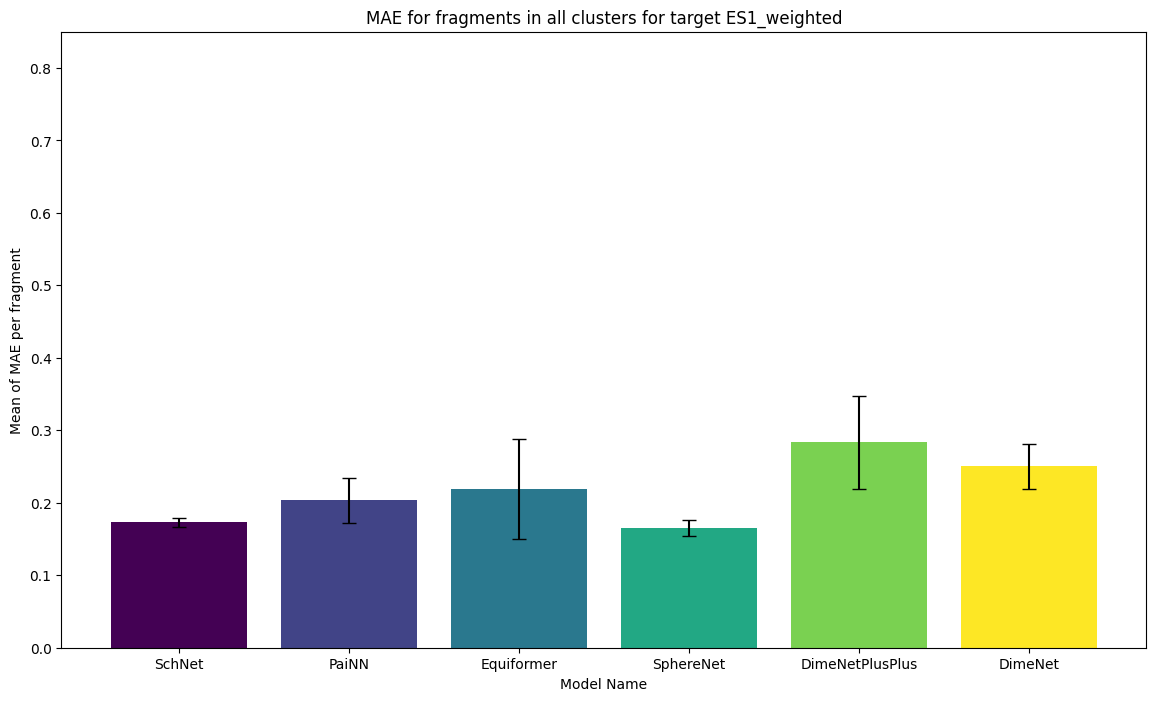

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis
import os

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] 
cluster_numbers = [1, 2, 3, 4, 5, 6]  

target = 'ES1'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Initialize lists to store means and standard errors for each model
means = []
std_errors = []

# Create a colormap
colors = viridis(np.linspace(0, 1, len(model_names)))

# Loop over model names
for model_name in model_names:
    # Initialize an empty list to store the means for the current model
    model_mean_diffs = []
    
    # Loop over cluster numbers
    for cluster in cluster_numbers:
        # Filter morgan_keys DataFrame by the current cluster
        cluster_morgan_keys = morgan_keys[morgan_keys['Cluster'] == cluster]
        
        # load the csv file for the cluster
        csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv'
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, index_col=0)

            # Calculate the mean of the mean_diff_{model}_ES1 column for the current cluster
            mean_diff = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}{weight}'])

            # Append the mean to the list
            model_mean_diffs.append(mean_diff)

    # Calculate the mean and standard error for the current model
    model_mean = np.nanmean(model_mean_diffs)
    model_std_error = np.nanstd(model_mean_diffs) / np.sqrt(len(model_mean_diffs))
    
    # Append to the lists
    means.append(model_mean)
    std_errors.append(model_std_error)

# Create a bar plot with error bars
plt.figure(figsize=(14, 8))
plt.bar(model_names, means, yerr=std_errors, capsize=5, color=colors)

# Add labels and title
plt.xlabel('Model Name')
plt.ylabel('Mean of MAE per fragment')
plt.title(f'MAE for fragments in all clusters for target {target}{weight}')
plt.ylim(0, 0.85)

plt.show()

/var/tmp/pbs.9216454.pbs/ipykernel_2622970/156890146.py:35: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])
/var/tmp/pbs.9216454.pbs/ipykernel_2622970/156890146.py:35: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])
/var/tmp/pbs.9216454.pbs/ipykernel_2622970/156890146.py:35: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])


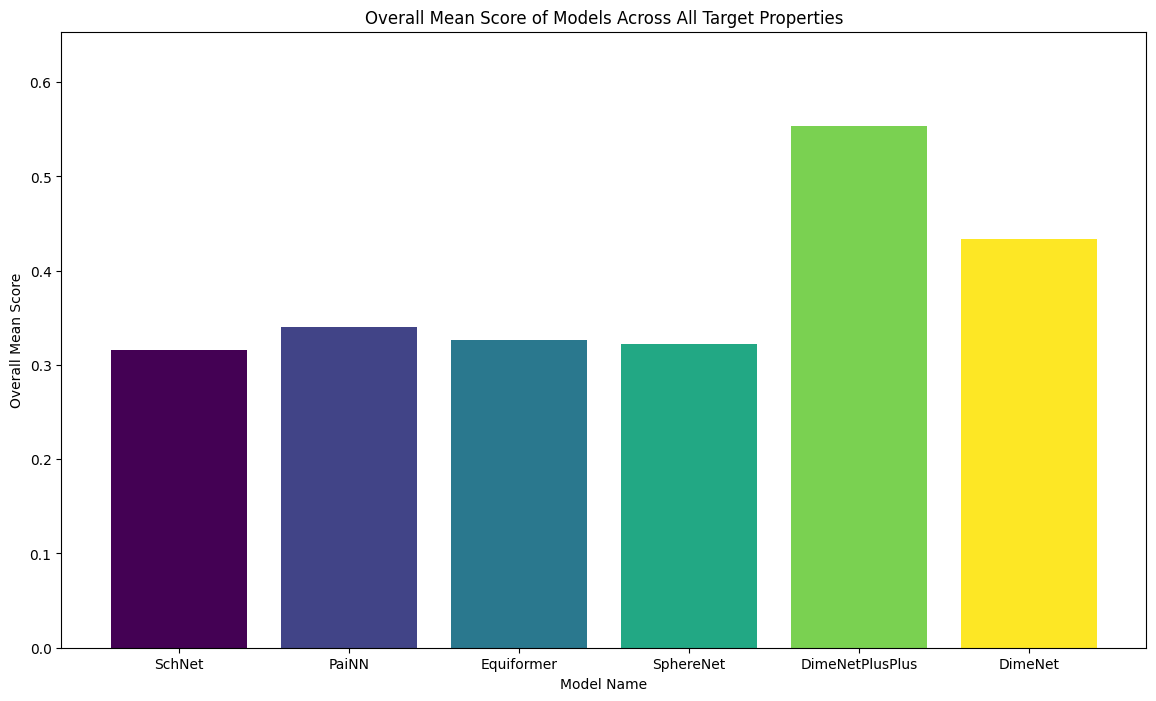

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis
import os

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] 
cluster_numbers = [1, 2, 3, 4, 5, 6]  
targets = ['IP', 'ES1', 'fosc1']  # List of target properties

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Initialize lists to store mean scores for each model and target
model_mean_scores = {model: [] for model in model_names}

# Loop over target properties
for target in targets:
    # Loop over model names
    for model_name in model_names:
        # Initialize an empty list to store the scores for the current model and target
        model_target_scores = []
        
        # Loop over cluster numbers
        for cluster in cluster_numbers:
            # Filter morgan_keys DataFrame by the current cluster
            cluster_morgan_keys = morgan_keys[morgan_keys['Cluster'] == cluster]
            
            # Load the CSV file for the cluster
            csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv'
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path, index_col=0)
                
                # Calculate the mean score for the current model and target in the current cluster
                mean_score = np.nanmean(cluster_morgan_keys[f'mean_diff_{model_name}_{target}'])
                
                # Append the mean score to the list
                model_target_scores.append(mean_score)
        
        # Calculate the mean score for the current model and target across all clusters
        model_mean_score = np.nanmean(model_target_scores)
        
        # Append the mean score to the list for the current model
        model_mean_scores[model_name].append(model_mean_score)

# Calculate the overall mean score for each model by averaging scores over all targets
overall_means = [np.mean(scores) for scores in model_mean_scores.values()]

# Create a bar plot of overall mean scores for each model
plt.figure(figsize=(14, 8))
plt.bar(model_names, overall_means, color=viridis(np.linspace(0, 1, len(model_names))))

# Add labels and title
plt.xlabel('Model Name')
plt.ylabel('Overall Mean Score')
plt.title('Overall Mean Score of Models Across All Target Properties')
plt.ylim(0, max(overall_means) + 0.1)

plt.show()


### Correlation between Number of Oligomers and Mean Difference per Fragment

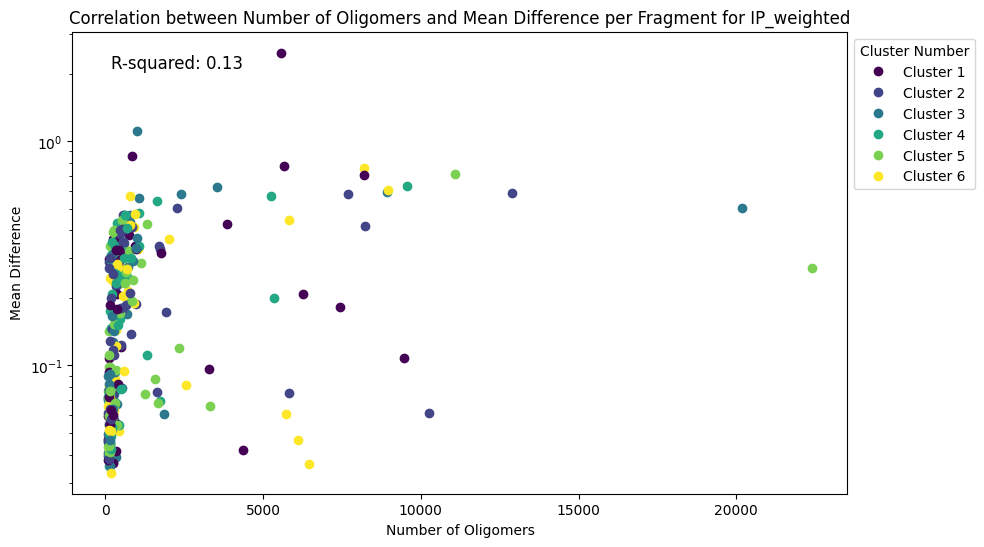

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.cm import viridis
import ast

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

target = 'IP'
weight = '_weighted'

oligomers = morgan_keys['Oligomers']
# mean_diff
mean_diff = morgan_keys[[f'mean_diff_SchNet_{target}{weight}', f'mean_diff_PaiNN_{target}{weight}', f'mean_diff_Equiformer_{target}{weight}', f'mean_diff_SphereNet_{target}{weight}', f'mean_diff_DimeNetPlusPlus_{target}{weight}', f'mean_diff_DimeNet_{target}{weight}']].mean(axis=1)


clusters = [1, 2, 3, 4, 5, 6] 

# Define colormap
colors = viridis(np.linspace(0, 1, len(clusters)))

# Calculate the mean difference for each fragment
mean_diff = mean_diff.apply(lambda x: np.nanmean(x))

# Plot
plt.figure(figsize=(10, 6))
legend_labels = []  # List to store legend labels
for i in range(len(oligomers)):
    plt.scatter(len(oligomers.iloc[i]), mean_diff.iloc[i], color=colors[i % len(colors)], alpha=0.99)
    legend_labels.append(f'Cluster {clusters[i % len(clusters)]}')

# Plot an invisible point for each cluster to create the legend
for i, cluster in enumerate(clusters):
    plt.plot([], [], 'o', label=f'Cluster {cluster}', color=colors[i])

plt.xlabel('Number of Oligomers')
plt.ylabel('Mean Difference')
plt.title(f'Correlation between Number of Oligomers and Mean Difference per Fragment for {target}{weight}')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Calculate linear regression
X = oligomers.apply(len).values.reshape(-1, 1)
y = mean_diff.values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Plot regression line
# plt.plot(X, y_pred, color='red', linewidth=2)

# Calculate r^2 score
r_squared = r2_score(y, y_pred)
plt.text(0.05, 0.95, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(title='Cluster Number', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## Inference test on test set

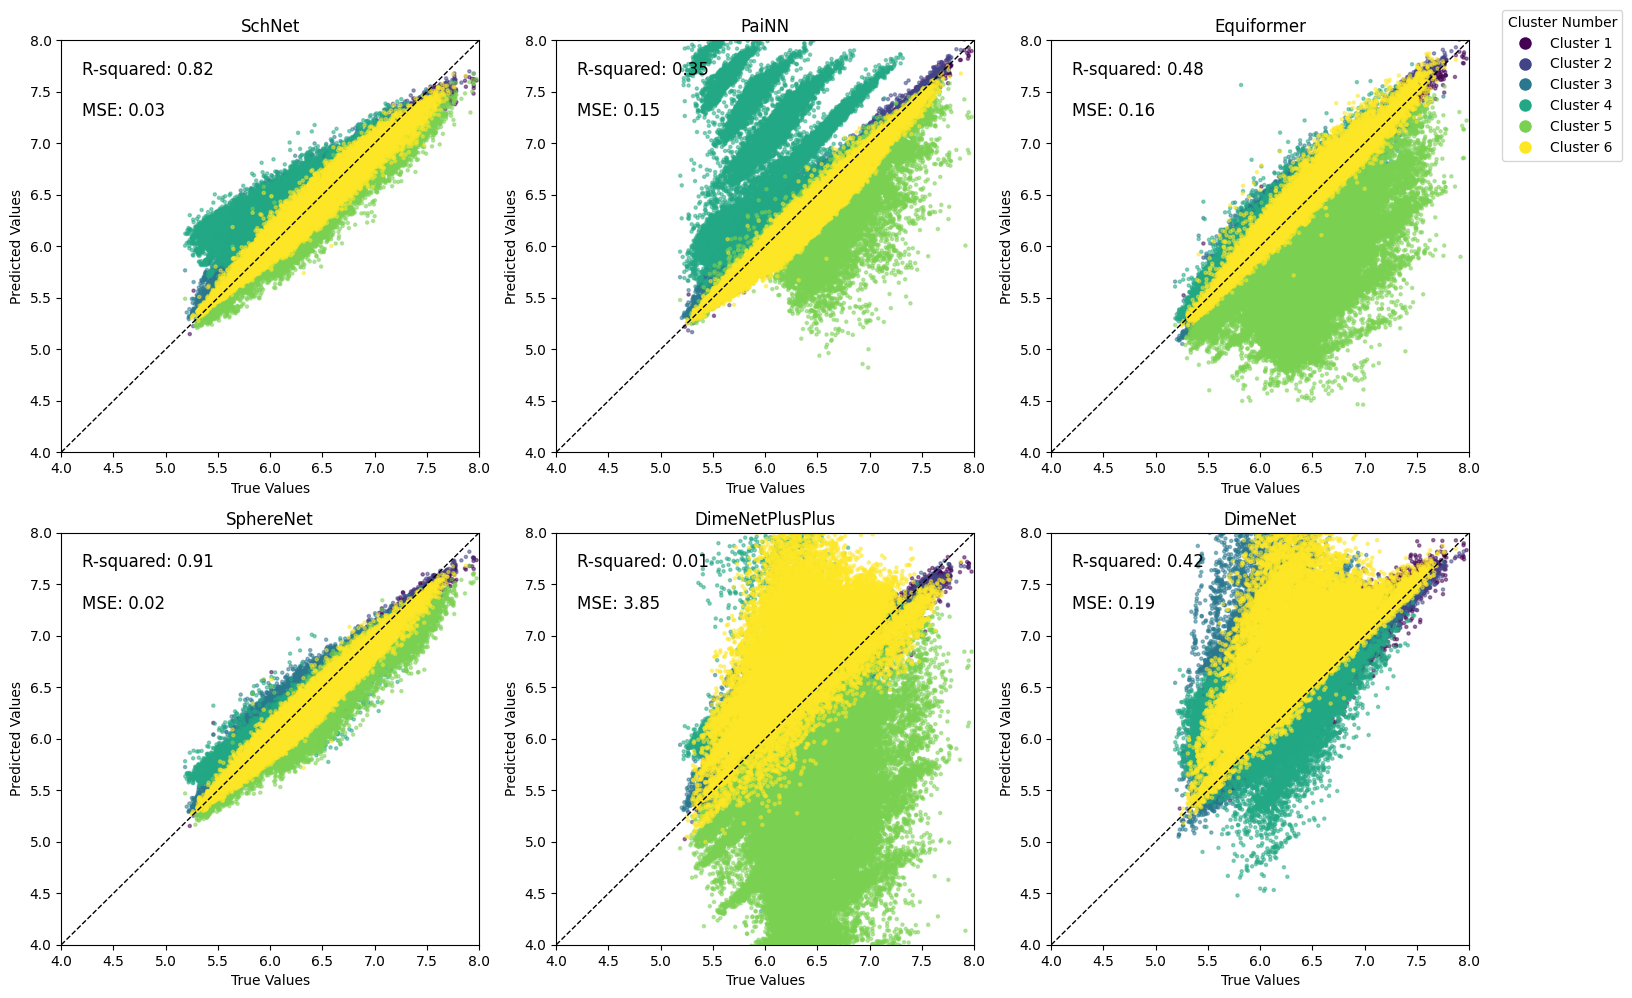

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.cm import viridis

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']  # Update with your actual model names
cluster_numbers = [1, 2, 3, 4, 5, 6]  # Update with your actual cluster numbers

target = 'IP'
weight = '_weighted'

x_lim = 8
y_lim = 8
x_min = 4
y_min = 4

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a colormap
colors = viridis(np.linspace(0, 1, len(cluster_numbers)))

# Iterate over each model
for model_idx, model_name in enumerate(model_names):
    # Create empty lists to store true and predicted values for all clusters
    all_y_true = []
    all_y_pred = []
    all_clusters = []
    
    # Iterate over each cluster
    for cluster_number in cluster_numbers:
        if model_name == 'DimeNet' and cluster_number == 5:
            continue
        else:
            # Load data for the current cluster
            file_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster_number}_cluster_{target}_model_inferences.csv'
            df = pd.read_csv(file_path, index_col=0)
            
            # Extract true and predicted values for the current cluster and model
            y_true = df[f'{model_name}_true_{target}']
            y_pred = df[f'{model_name}_pred_{target}']
            
            # Append to the lists
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)
            all_clusters.extend([cluster_number] * len(y_true))
    
    # Plot y_pred vs y_true in the corresponding subplot
    row = model_idx // 3
    col = model_idx % 3
    ax = axs[row, col]
    ax.scatter(all_y_true, all_y_pred, c=all_clusters, cmap='viridis', label='Cluster', alpha=0.5, s=5)

    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{model_name}')
    
    # Calculate linear regression
    reg = LinearRegression().fit(np.array(all_y_true).reshape(-1, 1), np.array(all_y_pred).reshape(-1, 1))
    y_pred_reg = reg.predict(np.array(all_y_true).reshape(-1, 1))
    
    # Calculate r^2 score
    r_squared = r2_score(all_y_pred, y_pred_reg)
    ax.text(0.05, 0.95, f'R-squared: {r_squared:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # put a straight line on the plot
    ax.plot([x_min, x_lim], [y_min, y_lim], color='black', linewidth=1, linestyle='--')

    # calculate the mean squared error
    mse = mean_squared_error(all_y_true, all_y_pred)
    ax.text(0.05, 0.85, f'MSE: {mse:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')


# Add cluster legend by saying which color is which cluster, not using a color bar
# Create a list of patches
patches = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}', markerfacecolor=colors[i], markersize=10) for i, cluster in enumerate(cluster_numbers)]
# Add the legend
fig.legend(handles=patches, title='Cluster Number', loc='upper left', bbox_to_anchor=(1, 1))

# change the y_lim and x_lim for all subplots
for ax in axs.flat:
    ax.set_xlim([x_min, x_lim])
    ax.set_ylim([y_min, y_lim])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Variation of performance of models on the different clusters

/var/tmp/pbs.9137156.pbs/ipykernel_1466067/1881853104.py:43: RuntimeWarning: Mean of empty slice
  cluster_mean = np.nanmean(mean_diffs)


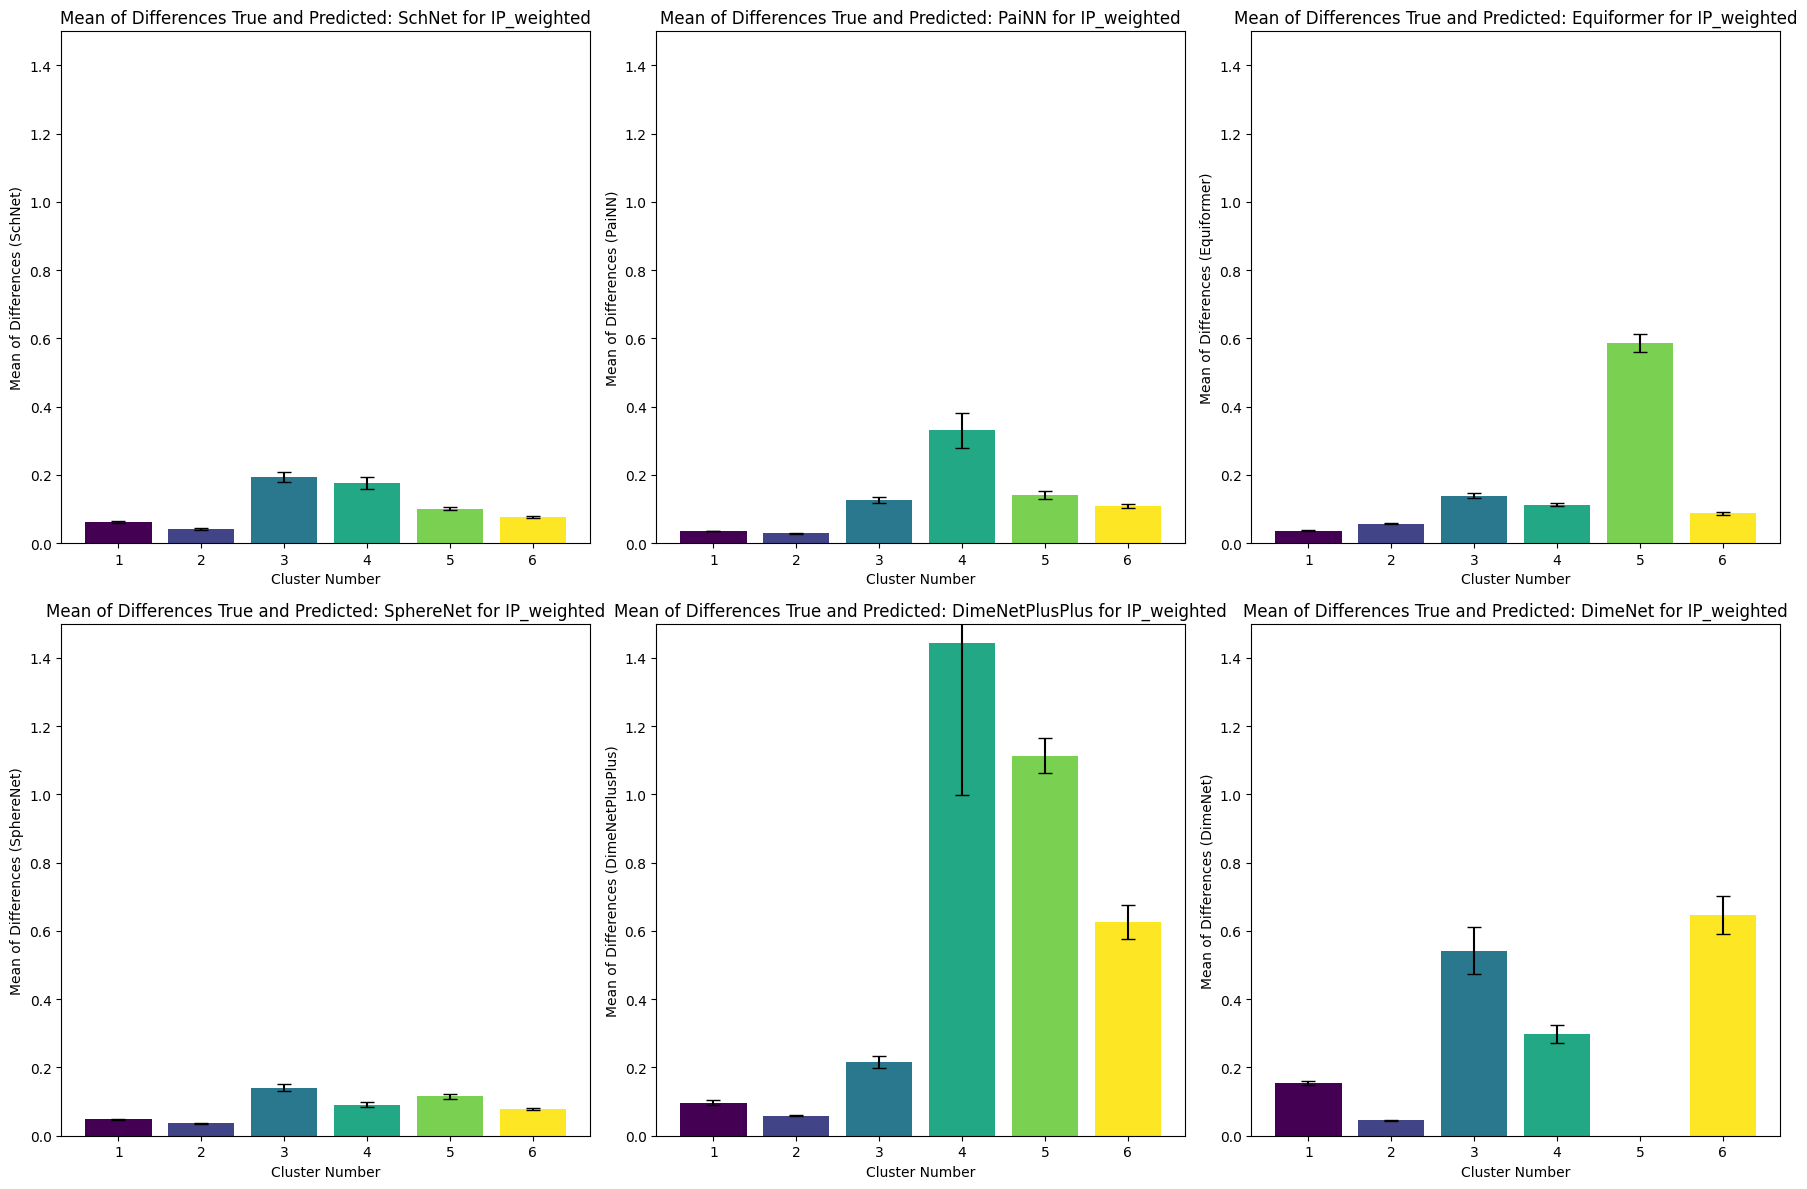

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis
import os

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet'] 
cluster_numbers = [1, 2, 3, 4, 5, 6]
target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Create a colormap
colors = viridis(np.linspace(0, 1, len(cluster_numbers)))

# Initialize a subplot index
subplot_index = 1

# Create a figure with multiple subplots
num_rows = len(model_names) // 3 + (len(model_names) % 3 > 0)
plt.figure(figsize=(18, 6*num_rows))
max_means = 1.5

for model_name in model_names:
    # Initialize lists to store means and standard errors for each cluster
    means = []
    std_errors = []
    length = []
    length_frag = []

    # Loop over cluster numbers
    for cluster in cluster_numbers:
        # Filter morgan_keys DataFrame by the current cluster
        cluster_morgan_keys = morgan_keys[morgan_keys['Cluster'] == cluster]

        # Calculate the mean of the mean_diff_{model}_ES1 column for the current cluster
        mean_diffs = cluster_morgan_keys[f'mean_diff_{model_name}_{target}{weight}'].dropna()
        
        # Calculate the mean and standard error for the current cluster
        cluster_mean = np.nanmean(mean_diffs)
        cluster_std_error = np.std(mean_diffs) / np.sqrt(len(mean_diffs))
        
        # Append to the lists
        means.append(cluster_mean)
        std_errors.append(cluster_std_error)

        # load the csv file for the cluster
        csv_path = f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv'
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, index_col=0)

        # add the length of the cluster to the length list for each cluster
        length.append(len(df))

        # print how many fragments are in each cluster by looking at morgan_keys dataframe
        length_frag.append(len(cluster_morgan_keys))

    # Create a subplot
    plt.subplot(num_rows, 3, subplot_index)

    # Create a bar plot with error bars
    plt.bar(cluster_numbers, means, yerr=std_errors, capsize=5, color=colors)
    
    # Add labels and title
    # set y_axis to log scale
    plt.ylim(0, max_means)  
    plt.xlabel('Cluster Number')
    plt.ylabel(f'Mean of Differences ({model_name})')
    plt.title(f'Mean of Differences True and Predicted: {model_name} for {target}{weight}')

    # Increment the subplot index
    subplot_index += 1

plt.tight_layout()
plt.show()


In [30]:
# save the morgan_keys dataframe to a pickle file
morgan_keys.to_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment/fragment_exp_results.pkl')

### Best and worst performing molecules

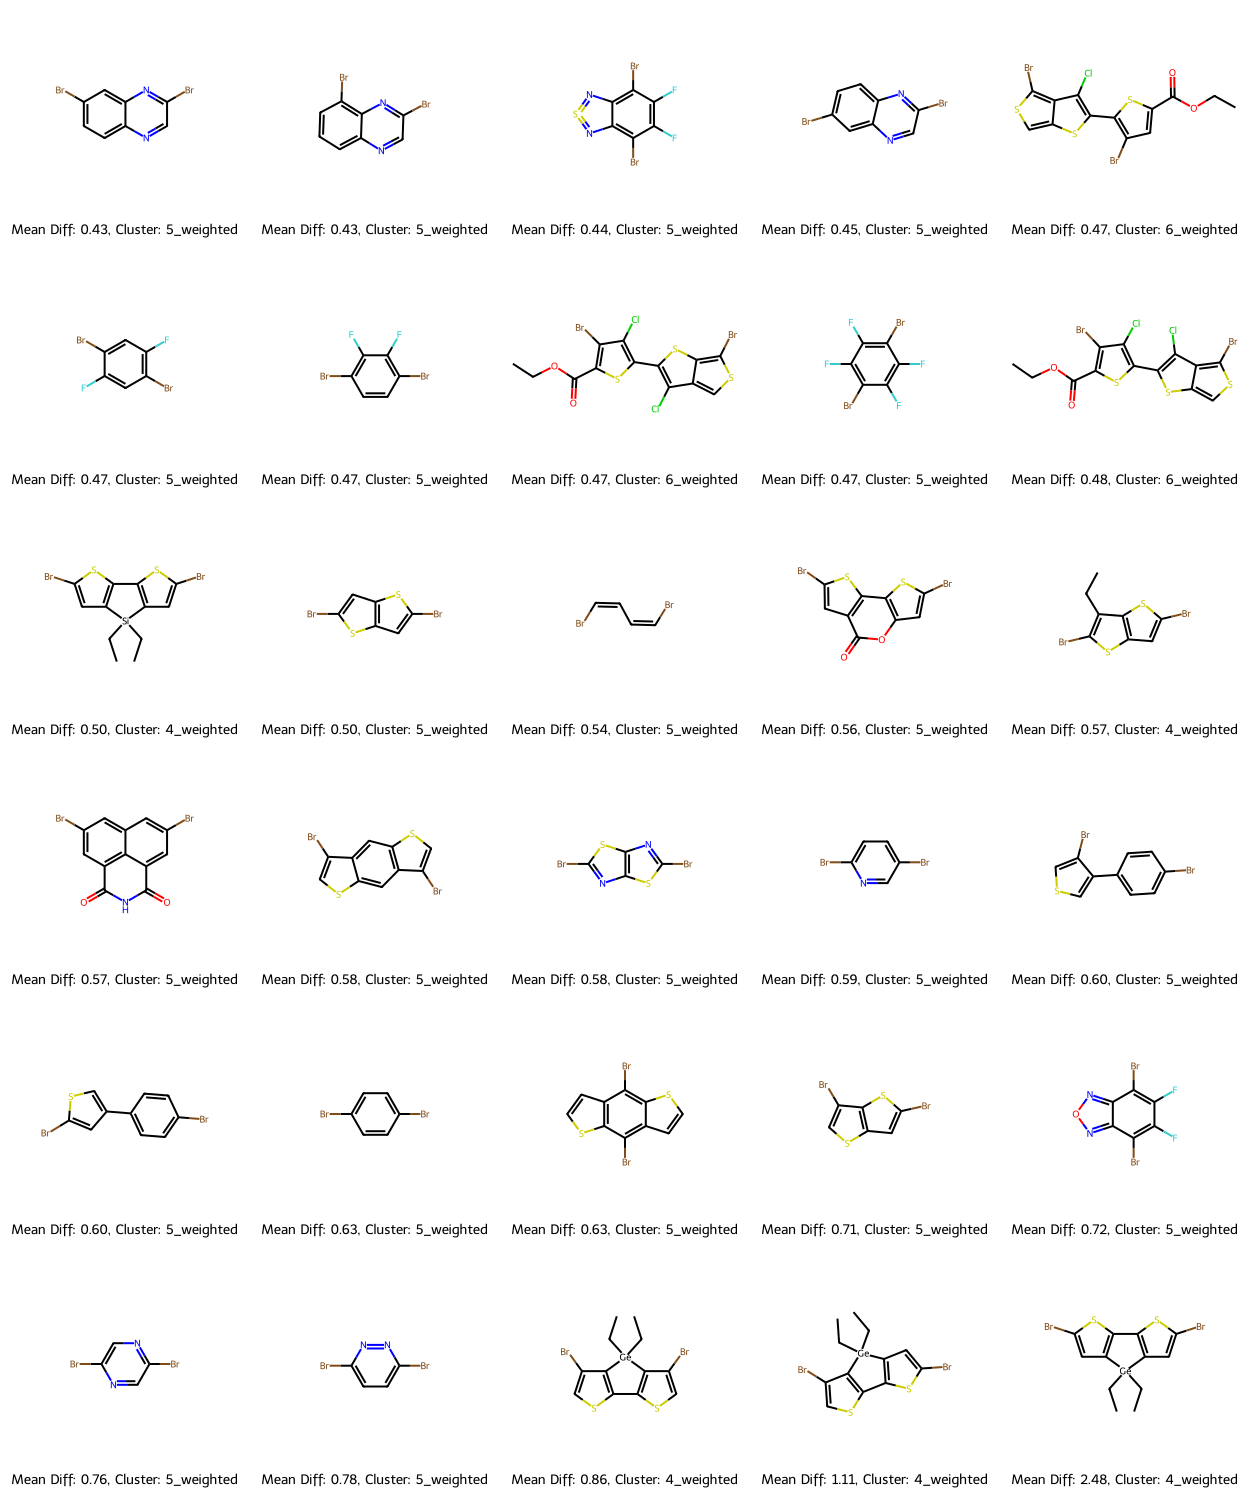

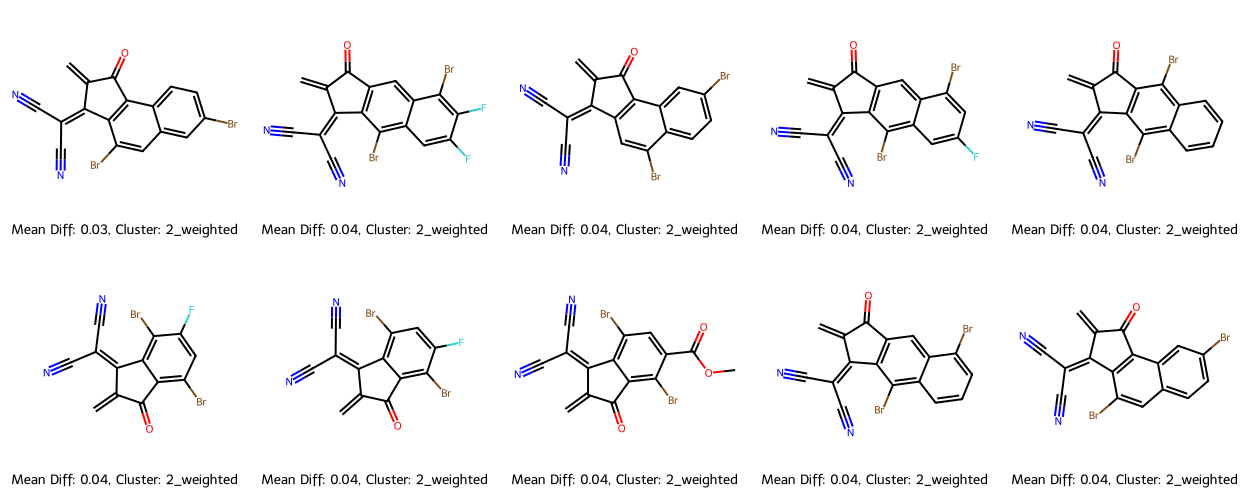

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Calculate mean difference for each fragment over all models, handling NaNs
mean_diff = np.nanmean([morgan_keys[f'mean_diff_{model}_{target}{weight}'] for model in model_names], axis=0)

# Find indices of the top and worst-performing molecules
worst_performing_indices = np.argsort(mean_diff)[-30:]
best_performing_indices = np.argsort(mean_diff)[:10]

# Function to collect molecules for each group (worst/best)
def get_molecules(indices):
    molecules = []
    for index in indices:
        smiles = morgan_keys['smiles'].iloc[index]
        molecules.append(Chem.MolFromSmiles(smiles))
    return molecules

# Get molecules for each set
worst_molecules = get_molecules(worst_performing_indices)
best_molecules = get_molecules(best_performing_indices)

# make a list with the mean differences of the worst performing molecules to use in the legend
worst_mean_diff = [mean_diff[i] for i in worst_performing_indices]

# make a list with the mean differences of the best performing molecules to use in the legend
best_mean_diff = [mean_diff[i] for i in best_performing_indices]

# Visualize molecules using MolsToGridImage
img = Draw.MolsToGridImage(worst_molecules, molsPerRow=5, subImgSize=(250,250), legends=[f'Mean Diff: {mean_diff:.2f}, Cluster: {morgan_keys["Cluster"].iloc[index]}{weight}' for mean_diff, index in zip(worst_mean_diff, worst_performing_indices)])
img2 = Draw.MolsToGridImage(best_molecules, molsPerRow=5, subImgSize=(250,250), legends=[f'Mean Diff: {mean_diff:.2f}, Cluster: {morgan_keys["Cluster"].iloc[index]}{weight}' for mean_diff, index in zip(best_mean_diff, best_performing_indices)])

# show the img
display(img)
display(img2)


In [100]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Calculate mean difference for each fragment over all models, handling NaNs
mean_diff = np.nanmean([morgan_keys[f'mean_diff_{model}_{target}{weight}'] for model in model_names], axis=0)

# Find indices of the top and worst-performing molecules
worst_performing_indices = np.argsort(mean_diff)[-10:]
best_performing_indices = np.argsort(mean_diff)[:10]

# Function to collect molecules for each group (worst/best)
def get_molecules(indices):
    molecules = []
    for index in indices:
        smiles = morgan_keys['smiles'].iloc[index]
        molecules.append(Chem.MolFromSmiles(smiles))
    return molecules

smarts_substructures = {
    'Sulfur': ('[s]', 'Sulfur'),
    'Oxygen': ('[o]', 'Oxygen'),
    'Nitrogen': ('[n]', 'Nitrogen'),
    'Halogen': ('[F,Cl,Br,I]', 'Halogen'),
    'Silicon': ('[Si]', 'Silicon'),
    'Germanium': ('[Ge]', 'Germanium')
}   

# Create a list of dictionaries
smarts_substructures_list = [{'smarts': smarts, 'name': name, 'Mol': Chem.MolFromSmarts(smarts)} for smarts, (smarts, name) in smarts_substructures.items()]

# Create a DataFrame from the list of dictionaries
smarts_substructures_df = pd.DataFrame(smarts_substructures_list)

def search(data):
    # Initialize lists to store matches and no matches
    matches = []
    no_matches = []

    # Iterate over molecules in the data
    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        mol = Chem.MolFromSmiles(row['smiles'])
        matched_substructures = []
        
        # Check for substructure matches
        for _, substruct in smarts_substructures_df.iterrows():
            substructure_matches = mol.GetSubstructMatches(substruct['Mol'])
            if substructure_matches:
                matched_substructures.extend(substructure_matches)
        
        # Store matches or no matches accordingly
        if matched_substructures:
            matches.append({
                'InChIKey': row['InChIKey'],
                'rdkit_mol': mol,
                'matched_substructures': matched_substructures
            })
        else:
            no_matches.append({
                'InChIKey': row['InChIKey'],
                'rdkit_mol': mol
            })

    # Convert matches and no_matches to DataFrames
    matches_df = pd.DataFrame(matches)
    no_matches_df = pd.DataFrame(no_matches)

    print(f'{matches_df.shape[0]} molecules have a match')
    print(f'{no_matches_df.shape[0]} molecules do not have a match')

    # Define highlight lists for molecules with matches
    highlight_lists = []
    if matches_df.shape[0] > 0:
        for _, row in matches_df.iterrows():
            h = []
            for substructure_match in row['matched_substructures']:
                h.extend(substructure_match)
            highlight_lists.append(h)

        # Convert matches['rdkit_mol'] to a list of RDKit molecule objects
        rdkit_mols_matches = matches_df['rdkit_mol'].tolist()

        if no_matches_df.shape[0] > 0:
            # Convert no_matches['rdkit_mol'] to a list of RDKit molecule objects
            rdkit_mols_no_matches = no_matches_df['rdkit_mol'].tolist()
            # Concatenate RDKit molecule lists
            rdkit_mols = rdkit_mols_matches + rdkit_mols_no_matches
            # Concatenate legends
            legends_matches = matches_df['InChIKey'].tolist()
            legends_no_matches = no_matches_df['InChIKey'].tolist()
            legends = legends_matches + legends_no_matches
            # Pad highlight_lists with empty lists for molecules without matched substructures
            highlight_lists += [[]] * (len(rdkit_mols) - len(highlight_lists))

        else:
            # Convert matches['rdkit_mol'] to a list of RDKit molecule objects
            rdkit_mols = rdkit_mols_matches
            # Concatenate legends
            legends_matches = matches_df['InChIKey'].tolist()
            legends = legends_matches
            # Pad highlight_lists with empty lists for molecules without matched substructures
            highlight_lists += [[]] * (len(rdkit_mols) - len(highlight_lists))
    else:
        # If no matches found, handle it accordingly
        rdkit_mols = no_matches_df['rdkit_mol'].tolist()
        legends = no_matches_df['InChIKey'].tolist()
        highlight_lists += [[]] * len(rdkit_mols)

    # Show in MolsGridImage all the molecules with the substructures highlighted
    img = Draw.MolsToGridImage(
        rdkit_mols, 
        molsPerRow=5, 
        subImgSize=(200, 200),
        legends=legends,
        highlightAtomLists=highlight_lists
    )

    display(img)

    return matches_df, no_matches_df

matches_df, no_matches_df = search(morgan_keys)


### Substructure matches vs error

In [3]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from tqdm import tqdm

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
target = 'IP'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

def calculate_fragment_errors(data, substructure_smarts):
    # Initialize dictionaries to store errors and counts for fragments with and without each substructure
    with_substructure_errors = {substructure: [] for substructure in substructure_smarts}
    without_substructure_errors = {substructure: [] for substructure in substructure_smarts}
    substructure_counts = {substructure: 0 for substructure in substructure_smarts}
    
    # Loop over fragments
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing fragments"):
        mol = Chem.MolFromSmiles(row['smiles'])
        
        # Loop over substructures
        for substructure, smarts in substructure_smarts.items():
            # Check for substructure matches
            substructure_matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))
            if substructure_matches:
                with_substructure_errors[substructure].append(np.nanmean([row[f'mean_diff_{model}_{target}{weight}'] for model in model_names]))
                substructure_counts[substructure] += 1
            else:
                without_substructure_errors[substructure].append(np.nanmean([row[f'mean_diff_{model}_{target}{weight}'] for model in model_names]))
                
    # Calculate mean errors for fragments with each substructure
    with_substructure_means = {substructure: np.mean(errors) for substructure, errors in with_substructure_errors.items()}
        
    # Calculate mean error for fragments without each substructure
    without_substructure_means = {substructure: np.mean(errors) for substructure, errors in without_substructure_errors.items()}

    # Sort substructures by counts in descending order
    substructure_counts = {k: v for k, v in sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True)}
    
    # Sort other dictionaries based on the sorted substructures
    with_substructure_means = {substructure: with_substructure_means[substructure] for substructure in substructure_counts}
    without_substructure_means = {substructure: without_substructure_means[substructure] for substructure in substructure_counts}
    
    return with_substructure_means, without_substructure_means, substructure_counts

# Define substructure smarts
substructure_smarts = {
    'Germanium': '[Ge]',
    'Silica': '[Si]',
    'Halogen': '[F,Cl,I]',
    'Thiophene': 'c1sccc1',
    'Pyrimidine': 'c1cnncc1',
    'DiFluoroBenzene': 'Fc1ccccc1F',
    'Methyl Acetate': 'cC(=O)OC',
    'Quinoxaline': 'c1ccc2nccnc2c1',
    'Cyanide': 'C#N',
    'DiThiophene': 's1cc2sccc2c1',
    'Benzene': 'c1ccccc1',
    'Ketone': 'C(=O)'
}

substructure_colors = {
    'Germanium': (1, 0, 0),  # red
    'Silica': (0, 0, 1),      # Blue
    'Halogen': (0, 1, 1),     # cyan
    'Thiophene': (0, 1, 0),    # green
    'Pyrimidine': (1, 1, 0),   # yellow
    'DiFluoroBenzene': (0, 0, 0),   # black
    'Methyl Acetate': (1, 0.5, 0), # orange 
    'Quinoxaline': (1, 0, 1), # magenta
    'Cyanide': (0.5, 0.5, 1), # light blue
    'DiThiophene': (1, 0.5, 0.5), # light red
    'Benzene': (0.5, 1, 0.5), # 
    'Ketone': (0.25, 0.25, 1) # grey

}

# Calculate mean errors for fragments with and without each substructure
with_substructure_means, without_substructure_means, substructure_counts  = calculate_fragment_errors(morgan_keys, substructure_smarts)

# Sort substructures by counts in descending order
sorted_substructures = {k: v for k, v in sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True)}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot mean errors for fragments with each substructure next to bar showing mean error for fragments without the substructure
bar_width = 0.6
index = np.arange(len(sorted_substructures))

for i, (substructure, count) in enumerate(sorted_substructures.items()):
    ax.bar(i - bar_width / 2, with_substructure_means[substructure], width=bar_width / 2, label=substructure, color=substructure_colors[substructure])
    ax.bar(i, without_substructure_means[substructure], width=bar_width / 2, color='grey')

# # make a dotten line shwing overall average of both with and without substructures
# overall_mean = np.mean(list(with_substructure_means.values()) + list(without_substructure_means.values()))
# ax.axhline(y=overall_mean, color='black', linestyle='--', label='Overall Mean')

ax.set_xlabel('Substructure Count')
ax.set_ylabel('Average Error')
ax.set_title(f'Average Error for Fragments with and without Substructures for {target}')
ax.set_xticks(np.arange(len(sorted_substructures)))
ax.set_xticklabels(sorted_substructures.values())

plt.legend()
plt.show()


Processing fragments: 100%|██████████| 310/310 [00:00<00:00, 1533.38it/s]


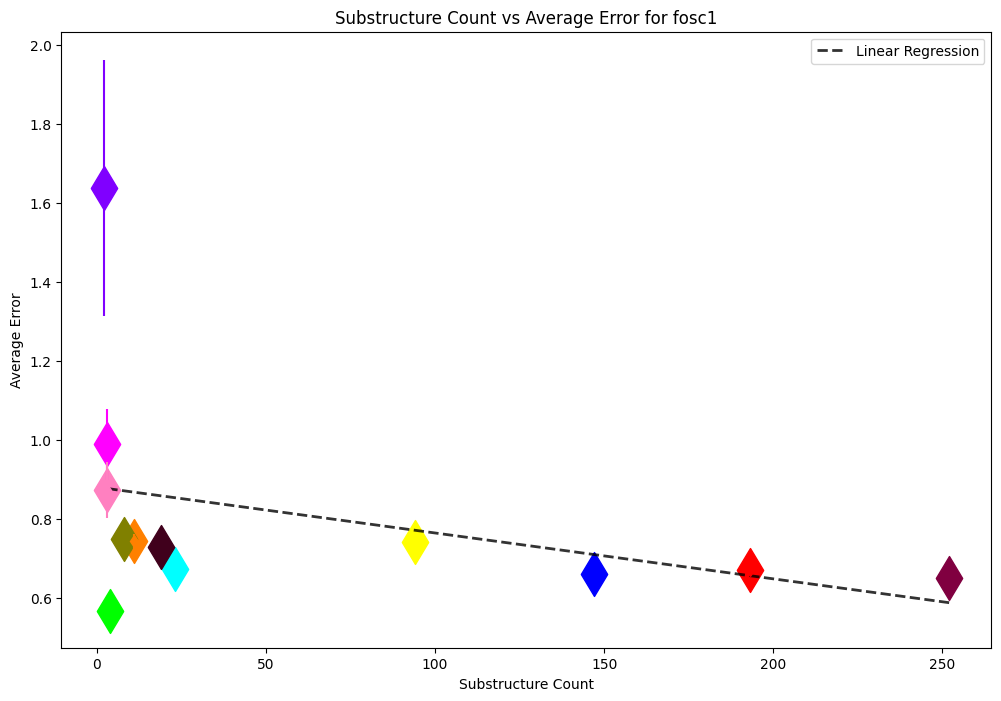

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
target = 'fosc1'
weight = '_weighted'

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

def calculate_fragment_errors(data, substructure_smarts):
    # Initialize dictionaries to store errors and counts for fragments with each substructure
    with_substructure_errors = {substructure: [] for substructure in substructure_smarts}
    without_substructure_errors = {substructure: [] for substructure in substructure_smarts}
    substructure_counts = {substructure: 0 for substructure in substructure_smarts}
    std_error = {substructure: [] for substructure in substructure_smarts}  # Initialize for standard error
    
    # Loop over fragments
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing fragments"):
        mol = Chem.MolFromSmiles(row['smiles'])
        
        # Loop over substructures
        for substructure, smarts in substructure_smarts.items():
            # Check for substructure matches
            substructure_matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))
            if substructure_matches:
                errors = [row[f'mean_diff_{model}_{target}{weight}'] for model in model_names]
                with_substructure_errors[substructure].extend(errors)
                substructure_counts[substructure] += 1
                std_error[substructure].extend(errors)  # Collect errors for standard error calculation
            else:
                without_substructure_errors[substructure].extend([row[f'mean_diff_{model}_{target}{weight}'] for model in model_names])
    
    # Calculate mean errors for fragments with each substructure
    with_substructure_means = {substructure: np.nanmean(errors) for substructure, errors in with_substructure_errors.items()}
    
    # Calculate standard error for each substructure
    std_error = {substructure: np.nanstd(errors) / np.sqrt(len(errors)) for substructure, errors in std_error.items()}

    # Calculate mean error for fragments without each substructure
    without_substructure_means = {substructure: np.nanmean(errors) for substructure, errors in without_substructure_errors.items()}

    # Sort substructures by counts in descending order
    substructure_counts = {k: v for k, v in sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True)}
    
    # Sort other dictionaries based on the sorted substructures
    with_substructure_means = {substructure: with_substructure_means[substructure] for substructure in substructure_counts}
    without_substructure_means = {substructure: without_substructure_means[substructure] for substructure in substructure_counts}
    
    return with_substructure_means, without_substructure_means, substructure_counts, std_error

# Define substructure smarts
substructure_smarts = {
    'Germanium': '[Ge]',
    'Silica': '[Si]',
    'Halogen': 'C([F,Cl,I])',
    'Thiophene': 'c1sccc1',
    'Pyrimidine': 'c1cnncc1',
    'DiFluoroBenzene': 'Fc1ccccc1F',
    'Methyl Acetate': 'cC(=O)OC',
    'Quinoxaline': 'c1ccc2nccnc2c1',
    'Cyanide': 'C#N',
    'DiThiophene': 's1cc2sccc2c1',
    'Benzene': 'c1ccccc1',
    'Ketone': 'C(=O)'
}


substructure_colors = {
    'Germanium': (1.0, 0.0, 1.0),       # red
    'Silica': (1.0, 0.5019607843137255, 0.7529411764705882),  # Blue
    'Halogen': (0.0, 1.0, 0.0),     # cyan
    'Thiophene': (1.0, 1.0, 0.0),    # green
    'Pyrimidine': (0.5019607843137255, 0.0, 1.0),   # yellow
    'DiFluoroBenzene': (0.0, 1.0, 1.0),   # black
    'Methyl Acetate': (1.0, 0.5019607843137255, 0.0), # orange 
    'Quinoxaline': (0.25098039215686274, 0.0, 0.10980392156862745), # magenta
    'Cyanide': (0.0, 0.0, 1.0), # light blue
    'DiThiophene': (0.5019607843137255, 0.5019607843137255, 0.0), # light red
    'Benzene': (0.5019607843137255, 0.0, 0.25098039215686274), # 
    'Ketone': (1.0, 0.0, 0.0) # grey
}


# Calculate mean errors for fragments with and without each substructure
with_substructure_means, without_substructure_means, substructure_counts, std_error  = calculate_fragment_errors(morgan_keys, substructure_smarts)

# Convert dictionaries to lists for scatter plot
substructure_counts_list = list(substructure_counts.values())
with_substructure_means_list = list(with_substructure_means.values())

# fit a linear regression model
X = np.array(substructure_counts_list).reshape(-1, 1)
y = np.array(with_substructure_means_list).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with error bars
for substructure, color in substructure_colors.items():
    x = substructure_counts[substructure]
    y = with_substructure_means[substructure]
    errors = std_error[substructure]  # Standard error
    ax.errorbar(x, y, yerr=errors, fmt='d', color=color)

# Increase the size of the diamonds
for substructure, color in substructure_colors.items():
    ax.scatter(substructure_counts[substructure], with_substructure_means[substructure], color=color, marker='d', s=500)

# Grey bars for 'without' substructures
# for substructure, mean_error in without_substructure_means.items():
    # ax.scatter(substructure_counts[substructure], mean_error, color='black', marker='x', alpha=0.8)

# plot the linear regression line
ax.plot(X, y_pred, color='black', linestyle='--', linewidth=2, label='Linear Regression', alpha=0.8)

ax.set_xlabel('Substructure Count')
ax.set_ylabel('Average Error')
ax.set_title(f'Substructure Count vs Average Error for {target}')
# plt.ylim(0, 1.6)
plt.legend()
plt.show()


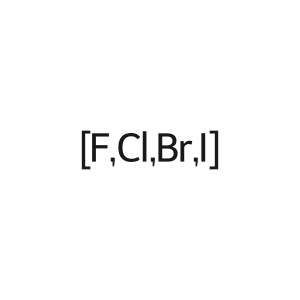

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw

# Define the SMARTS pattern for quinoxaline
quinoxaline_smarts = '[F,Cl,Br,I]'

# Convert SMARTS to a molecule object
mol = Chem.MolFromSmarts(quinoxaline_smarts)

# Draw the molecule
Draw.MolToImage(mol)


### MW vs Error

Calculating MW: 100%|██████████| 310/310 [00:00<00:00, 3929.74it/s]


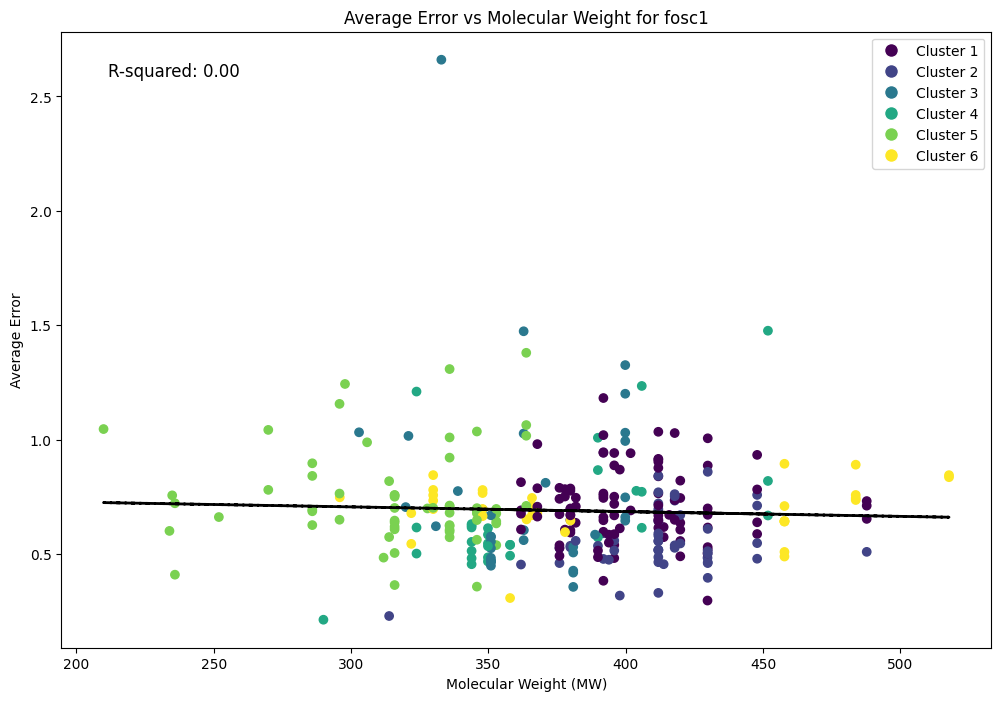

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm
from rdkit import Chem
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem import Descriptors

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')
model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
# model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet']
target = 'fosc1'

# Calculate molecular weight (MW) for each fragment
mw_list = []
for index, row in tqdm(morgan_keys.iterrows(), total=morgan_keys.shape[0], desc="Calculating MW"):
    mol = Chem.MolFromSmiles(row['smiles'])
    mw = Descriptors.ExactMolWt(mol)
    mw_list.append(mw)

# Add a new column 'MW' to the dataframe
morgan_keys['MW'] = mw_list

# Calculate the average error for the specified target over all models
y = np.nanmean([morgan_keys[f'mean_diff_{model}_{target}_weighted'] for model in model_names], axis=0)

# Extract MW values for plotting
X = morgan_keys['MW'].values.reshape(-1, 1)

# Fit a linear regression model
reg = LinearRegression().fit(X, y.reshape(-1, 1))
y_pred = reg.predict(X)

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot colored by cluster number
cluster_colors = morgan_keys['Cluster']
cmap = plt.get_cmap('viridis')
normalize = Normalize(vmin=min(cluster_colors), vmax=max(cluster_colors))
colors = [cmap(normalize(value)) for value in cluster_colors]

scatter = ax.scatter(morgan_keys['MW'], y, c=cluster_colors, cmap='viridis')

# Plot linear regression line
ax.plot(X, y_pred, color='black', linestyle='--', linewidth=2, label=f'Linear Regression (R2={r2:.2f})')
# show the r2 score on the plot
ax.text(0.05, 0.95, f'R-squared: {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlabel('Molecular Weight (MW)')
ax.set_ylabel('Average Error')
ax.set_title(f'Average Error vs Molecular Weight for {target}')

# Create legend manually
unique_clusters = np.unique(cluster_colors)
handles = []
labels = []
for cluster in unique_clusters:
    label = f'Cluster {cluster}'
    color = cmap(normalize(cluster))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label)

ax.legend(handles, labels, loc='upper right')

plt.show()


Calculating CT: 100%|██████████| 310/310 [00:00<00:00, 1127.90it/s]


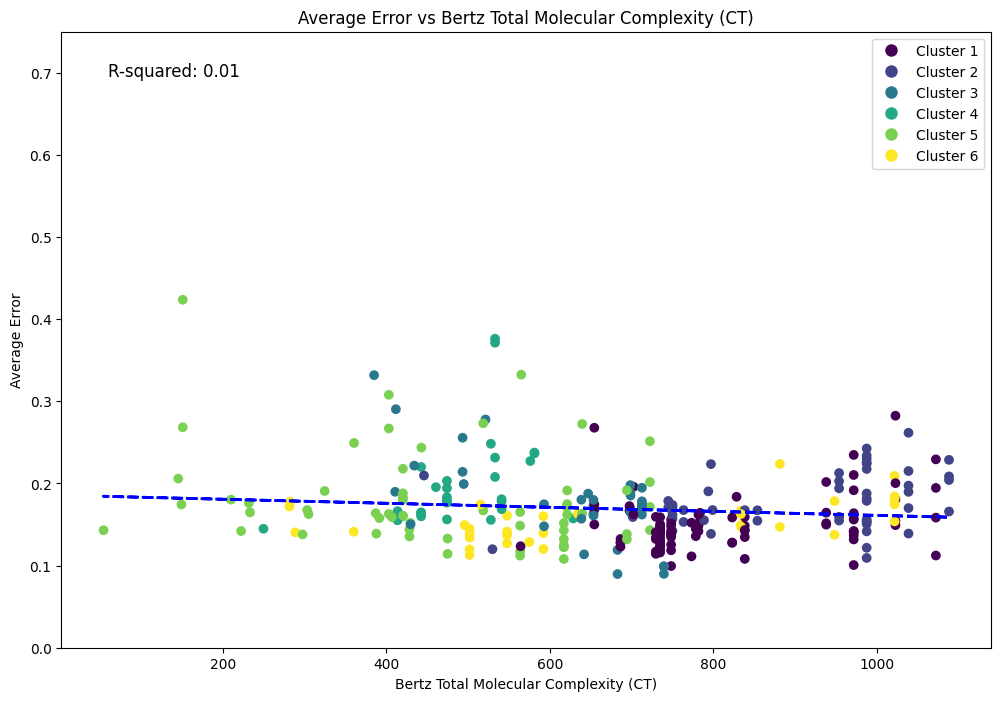

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm
from rdkit import Chem
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem import Descriptors, GraphDescriptors

# Load the morgan_keys dataframe
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')
model_names = ['SchNet'] #'Equiformer', 'SphereNet', 'DimeNet', 'DimeNetPlusPlus'
target = 'ES1'
ylim = 0.75

# Calculate Bertz Total Molecular Complexity (CT) for each fragment
ct_list = []
for index, row in tqdm(morgan_keys.iterrows(), total=morgan_keys.shape[0], desc="Calculating CT"):
    mol = Chem.MolFromSmiles(row['smiles'])
    ct = GraphDescriptors.BertzCT(mol)
    ct_list.append(ct)

# Add a new column 'CT' to the dataframe
morgan_keys['CT'] = ct_list

# Extract CT and error values for plotting
X = morgan_keys['CT'].values.reshape(-1, 1)
y = np.nanmean([morgan_keys[f'mean_diff_{model}_{target}_weighted'] for model in model_names], axis=0)

# Fit a linear regression model
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot colored by cluster number
cluster_colors = morgan_keys['Cluster']
cmap = plt.get_cmap('viridis')
normalize = Normalize(vmin=min(cluster_colors), vmax=max(cluster_colors))
colors = [cmap(normalize(value)) for value in cluster_colors]

scatter = ax.scatter(morgan_keys['CT'], y, c=cluster_colors, cmap='viridis')

# Plot linear regression line
ax.plot(X, y_pred, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (R2={r2:.2f})')

# Show the R-squared score on the plot
ax.text(0.05, 0.95, f'R-squared: {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlabel('Bertz Total Molecular Complexity (CT)')
ax.set_ylabel('Average Error')
ax.set_title('Average Error vs Bertz Total Molecular Complexity (CT)')

# Create legend manually
unique_clusters = np.unique(cluster_colors)
handles = []
labels = []
for cluster in unique_clusters:
    label = f'Cluster {cluster}'
    color = cmap(normalize(cluster))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label)

ax.legend(handles, labels, loc='upper right')
plt.ylim(0, ylim)

plt.show()


## Feature importance calculation

In [ ]:
# plot the fragments in a spec cluster
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
target = 'fosc1'

# Load the morgan_keys dataframe
morgan_keys2 = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

cluster1_indices = morgan_keys[morgan_keys['Cluster'] == 1].index

# Function to collect molecules for each group (worst/best)
def get_molecules(indices):
    molecules = []
    for index in indices:
        smiles = morgan_keys['smiles'].iloc[index]
        molecules.append(Chem.MolFromSmiles(smiles))
    return molecules

# Get molecules for each set
molecules = get_molecules(cluster1_indices)

print('Number of molecules:', len(molecules))
print(molecules[0])

# Visualize molecules using MolsToGridImage and legend should be corresponding inchikeys
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(200, 200))

# show the img
display(img)

In [26]:
import pandas as pd
from multiprocessing import freeze_support

from rdkit import Chem
from mordred import Calculator, descriptors

def calculate_descriptors(data, smiles_column='smiles'):
  """
  Calculates molecular descriptors for a DataFrame containing SMILES strings.

  Args:
      data (pd.DataFrame): DataFrame containing molecules (SMILES column specified by 'smiles_column').
      smiles_column (str, optional): Name of the column containing SMILES strings. Defaults to 'smiles'.

  Returns:
      pd.DataFrame: DataFrame containing calculated descriptors for each molecule.
  """

  mols = data['X_frag_mol']

  # Create Calculator
  calc = Calculator(descriptors)

  # Calculate descriptors using pandas method with error handling
  try:
    descriptors_df = calc.pandas(mols)
  except Exception as e:
    print(f"Error calculating descriptors: {e}")
    return None

  # Add the original InChIKey column back if it exists
  if 'InChIKey' in data.columns:
    descriptors_df['InChIKey'] = data['InChIKey']

  return descriptors_df



In [ ]:
descriptors_df.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/descriptors.csv')

In [81]:
# make a new column in the morgan_keys dataframe 'mean_diff_average' which is the mean of the mean differences of all the models, do not include the NaN values
target = 'fosc1'
weight = ''

# Calculate mean difference for each fragment over all models, handling NaNs
mean_diff = np.nanmean([morgan_keys[f'mean_diff_{model}_{target}{weight}'] for model in model_names], axis=0)

# Add the mean_diff_average column to the morgan_keys dataframe
morgan_keys[f'mean_diff_average_{target}{weight}'] = mean_diff

# see how many NaN values are in the mean_diff_average column
morgan_keys[f'mean_diff_average_{target}{weight}'].isna().sum()


0

In [82]:
morgan_keys.to_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

In [ ]:
morgan_keys.head()

Feature importances for Random Forest for IP:
ATS5s: 0.0812
TopoPSA(NO): 0.0688
GATS1dv: 0.0604


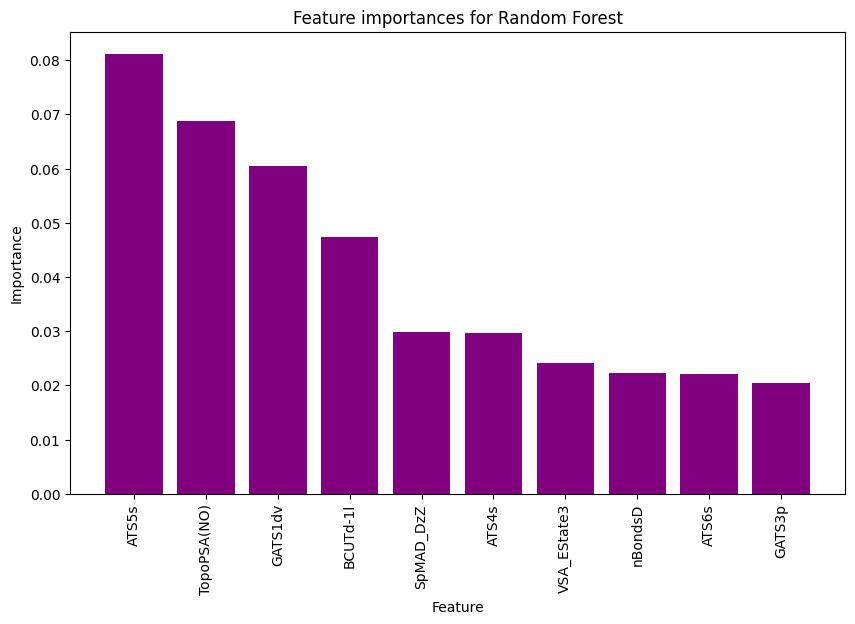

In [112]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

target = 'IP'
weight = '_weighted'

# load descriptors dataframe
descriptors_df = pd.read_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/descriptors.csv', index_col=0)
# load morgan_keys pickle file
morgan_keys = pd.read_pickle('/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl')

# Store feature names before imputation
feature_names = descriptors_df.columns[:-2]  # Exclude last two columns
descriptors = descriptors_df.iloc[:, :-2]

# Imputation and handle UserWarning
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(descriptors)
# y is the column 'mean_diff_average_fosc1'
y = morgan_keys[f'mean_diff_average_{target}{weight}']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = [
    ("Random Forest", RandomForestRegressor(random_state=42)),
    # ("Extra Trees", ExtraTreesRegressor(random_state=42))
]

for model_name, model in models:
    # Train
    model.fit(X_train, y_train)

    # Feature importances
    importances = model.feature_importances_

    # Sort by importance
    sorted_idx = importances.argsort()[::-1]
    sorted_features = feature_names[sorted_idx]  # Use stored feature names
    sorted_importances = importances[sorted_idx]

    # Print results
    print(f"Feature importances for {model_name} for {target}:")
    for i in range(3):
        print(f"{sorted_features[i]}: {sorted_importances[i]:.4f}")

    # plot the feature importances for the model for the top 10 features
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances for {model_name}")
    plt.bar(range(10), sorted_importances[:10], align="center", color='purple')
    plt.xticks(range(10), sorted_features[:10], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()
    


### Distributions

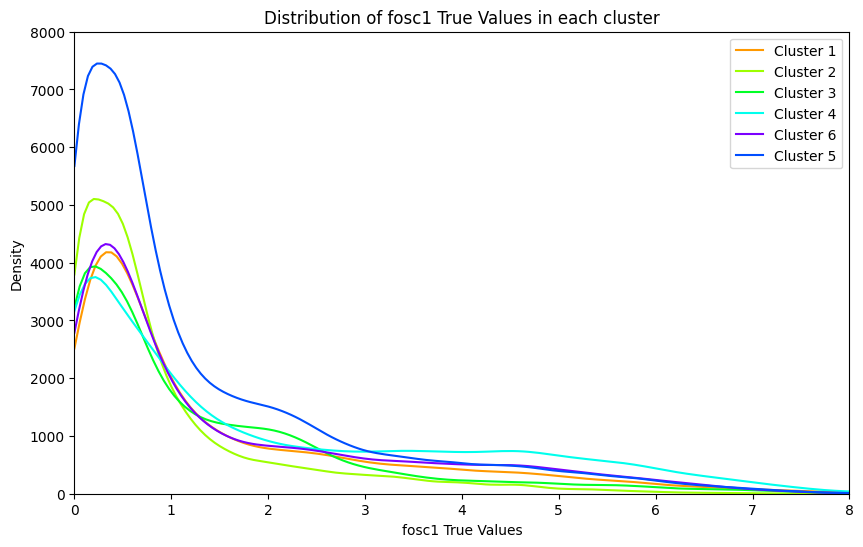

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model_name = 'SchNet'  

cluster_numbers = [1, 2, 3, 4, 6, 5]
target = 'fosc1'

# Initialize a new figure
plt.figure(figsize=(10, 6))

# get viridis color map
colors = sns.color_palette("gist_rainbow", len(cluster_numbers))

# Iterate over each cluster
for cluster in cluster_numbers:
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)

    # Get the column name for the current model's true values
    true_col = f'{model_name}_true_{target}'
        
    # Plot the KDE of true values for the current model and cluster
    sns.histplot(df_cluster[true_col], color=colors[cluster-1], kde=True, alpha=0, bins=50, label=f'Cluster {cluster}', fill=False)

# Set plot title and labels
plt.title(f'Distribution of {target} True Values in each cluster')
plt.xlabel(f'{target} True Values')
plt.ylabel('Density')

# Add legend
plt.legend([f'Cluster {cluster}' for cluster in cluster_numbers])

plt.xlim(0, 8)
plt.ylim(0,8000)

# Show plot
plt.show()


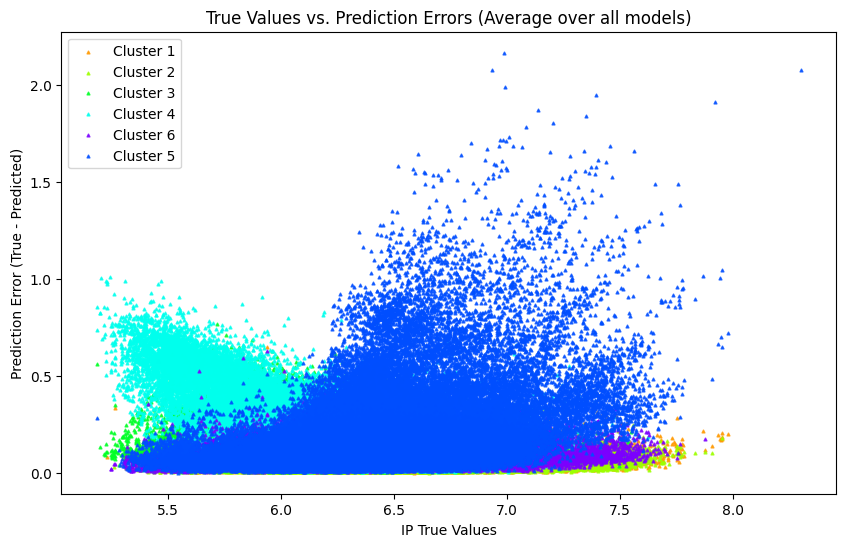

In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
cluster_numbers = [1, 2, 3, 4, 6, 5]

target = 'IP'

# Initialize a new figure
plt.figure(figsize=(10, 6))

# get viridis color map
colors = sns.color_palette("gist_rainbow", len(cluster_numbers))

# Iterate over each cluster
for cluster in cluster_numbers:
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)
    
    # Initialize an empty list to store errors for all models
    all_model_errors = []
    
    # Iterate over each model
    for model_name in model_names:
        if model_name == 'DimeNet' and cluster == 5:
            continue
        # Get the column names for the true and predicted values
        true_col = f'{model_name}_true_{target}'
        pred_col = f'{model_name}_pred_{target}'
        
        # Calculate the error for the current model
        error = abs(df_cluster[true_col] - df_cluster[pred_col])
        
        # Append the error to the list of errors for all models
        all_model_errors.append(error)
    
    # Calculate the average error across all models
    average_error = pd.concat(all_model_errors, axis=1).median(axis=1)

    # scatter plot of the average error for each cluster
    plt.scatter(df_cluster[true_col], average_error, color=colors[cluster-1], label=f'Cluster {cluster}', alpha=0.8, s=4, marker='^')

# Set plot title and labels
plt.title(f'True Values vs. Prediction Errors (Average over all models)')
plt.xlabel(f'{target} True Values')
plt.ylabel('Prediction Error (True - Predicted)')

# Add legend
plt.legend()

# Show plot
plt.show()


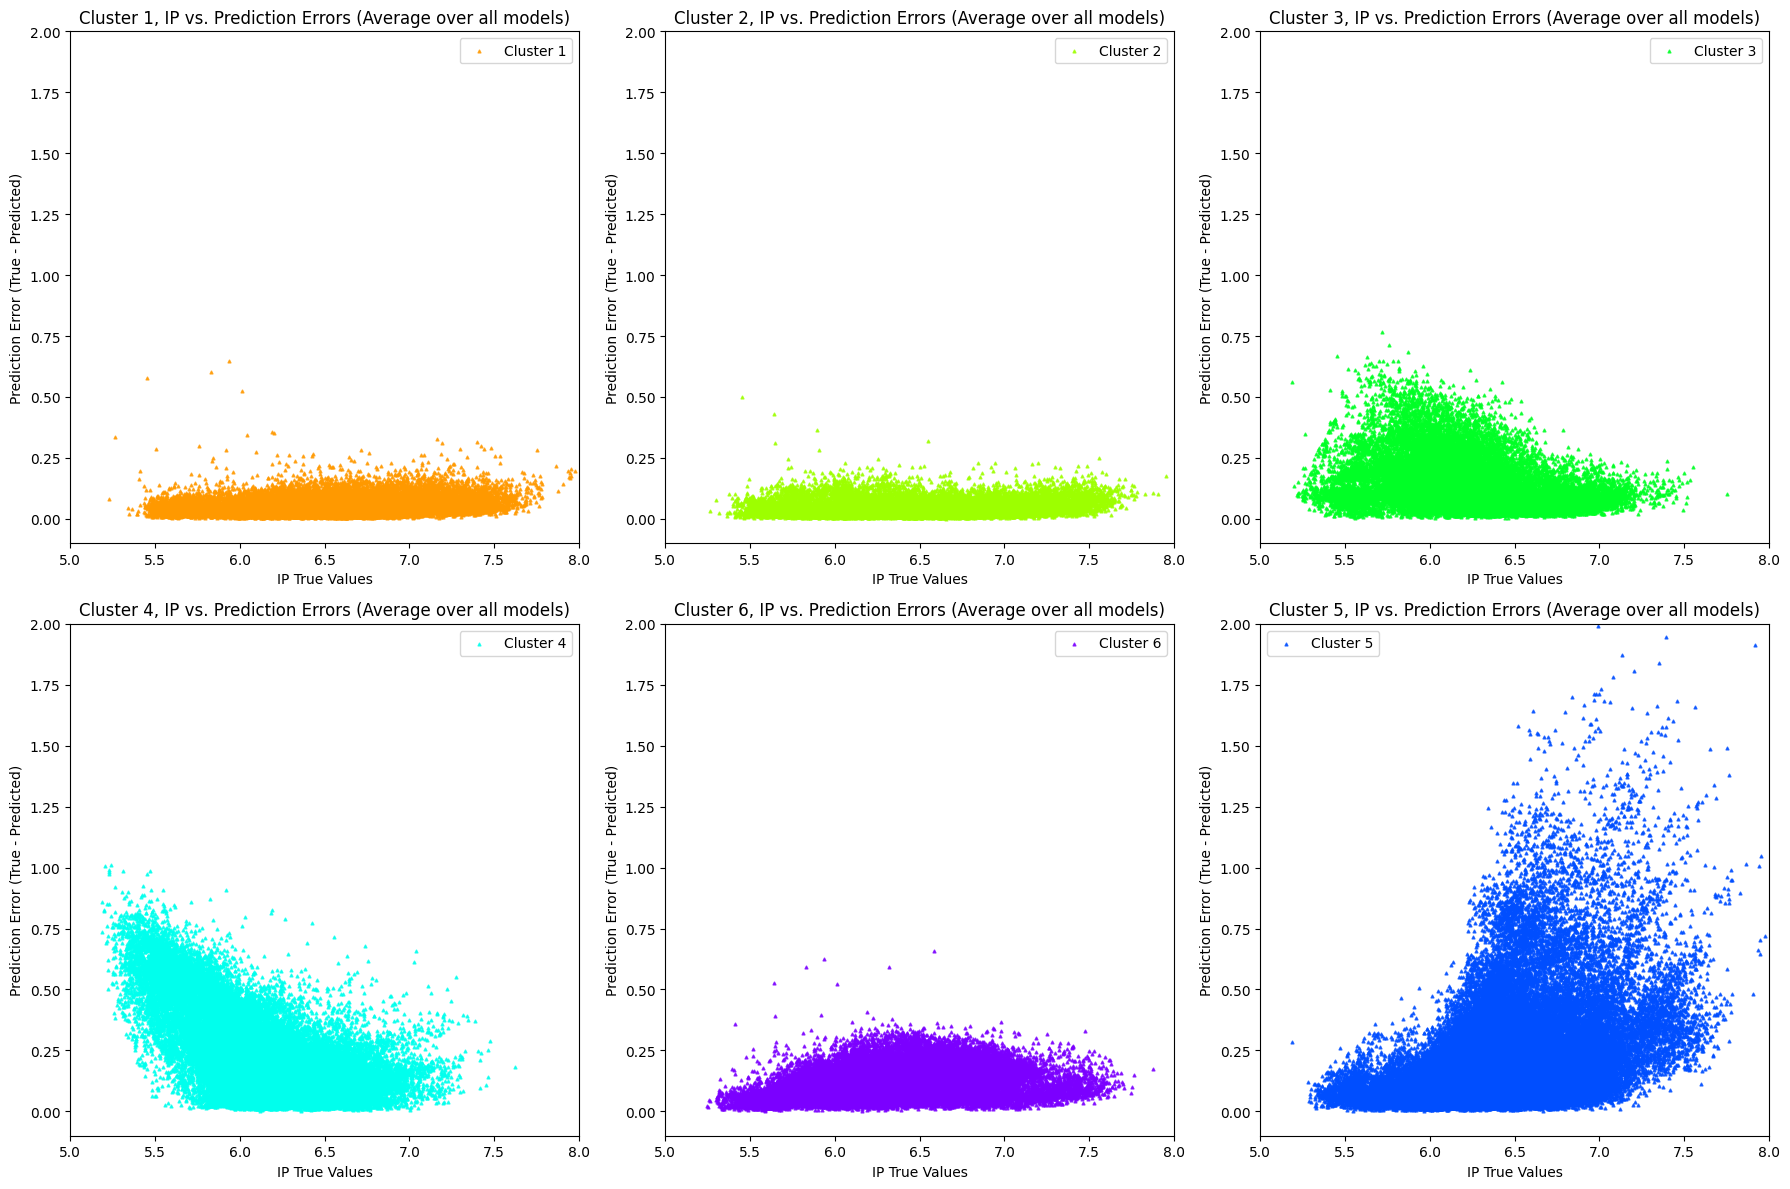

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['SchNet', 'PaiNN', 'Equiformer', 'SphereNet', 'DimeNetPlusPlus', 'DimeNet']
cluster_numbers = [1, 2, 3, 4, 6, 5] 

x_lim = 8
y_lim = 2
x_min = 5
y_min = -0.1

target = 'IP'

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5)

# get viridis color map
colors = sns.color_palette("gist_rainbow", len(cluster_numbers))

# Iterate over each cluster
for i, cluster in enumerate(cluster_numbers):
    # Load the dataframe for the current cluster
    df_cluster = pd.read_csv(f'/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/{cluster}_cluster_{target}_model_inferences.csv', index_col=0)
    
    # Initialize an empty list to store errors for all models
    all_model_errors = []
    
    # Iterate over each model
    for model_name in model_names:
        if model_name == 'DimeNet' and cluster == 5:
            continue
        # Get the column names for the true and predicted values
        true_col = f'{model_name}_true_{target}'
        pred_col = f'{model_name}_pred_{target}'
        
        # Calculate the error for the current model
        error = abs(df_cluster[true_col] - df_cluster[pred_col])
        
        # Append the error to the list of errors for all models
        all_model_errors.append(error)
    
    # Calculate the average error across all models
    average_error = pd.concat(all_model_errors, axis=1).median(axis=1)

    # scatter plot of the average error for each cluster
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(df_cluster[true_col], average_error, color=colors[cluster-1], label=f'Cluster {cluster}', alpha=0.8, s=4, marker='^')
    ax.set_title(f'Cluster {cluster}, {target} vs. Prediction Errors (Average over all models)')
    ax.set_xlabel(f'{target} True Values')
    ax.set_ylabel('Prediction Error (True - Predicted)')
    # set the x and y limits
    ax.set_xlim(x_min, x_lim)
    ax.set_ylim(y_min, y_lim)
    ax.legend()

# Show plot
plt.tight_layout()
plt.show()


## Similarity of fragments

In [1]:
import os
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw, rdFMCS
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.decomposition import PCA

from geom3d.train_models import *
import torch
import copy
import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/datasize_study/SchNet_opt_combined_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/80000dataset_combined.pt"
dataset = torch.load(dataset_path)

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/SchNet_opt_combined_80000


In [2]:
import importlib
from geom3d.utils import database_utils
from pathlib import Path


importlib.reload(database_utils)

df_path = Path(
    config["STK_path"], "data/output/Full_dataset/", config["df_total"]
)
df_precursors_path = Path(
    config["STK_path"],
    "data/output/Prescursor_data/",
    config["df_precursor"],
)

df_precursors = pd.read_pickle(df_precursors_path)

df_total, df_precursors = database_utils.load_data_from_file(
    df_path, df_precursors_path
)


In [3]:
def calculate_morgan_fingerprints(mols):
    morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]
    return morgan_fps

def calculate_tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [4]:
%matplotlib inline

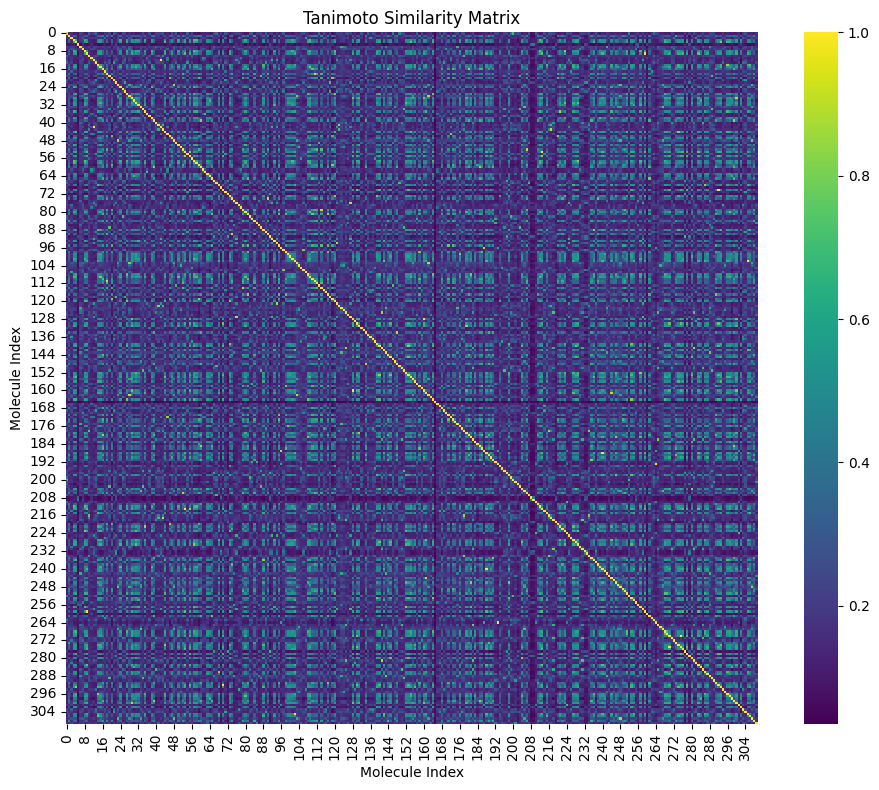

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_frag_mol = df_precursors['mol_opt_2'].values

morgan_fps = calculate_morgan_fingerprints(X_frag_mol)
tanimoto_sim = np.zeros((len(X_frag_mol), len(X_frag_mol)))
for i in range(len(X_frag_mol)):
    for j in range(len(X_frag_mol)):
        tanimoto_sim[i,j] = calculate_tanimoto_similarity(morgan_fps[i], morgan_fps[j])
        tanimoto_sim[j,i] = tanimoto_sim[i,j]

# Plot heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(tanimoto_sim, cmap="viridis", annot=False, fmt=".2f", square=True)
plt.title("Tanimoto Similarity Matrix")
plt.xlabel("Molecule Index")
plt.ylabel("Molecule Index")
plt.tight_layout()
plt.show()

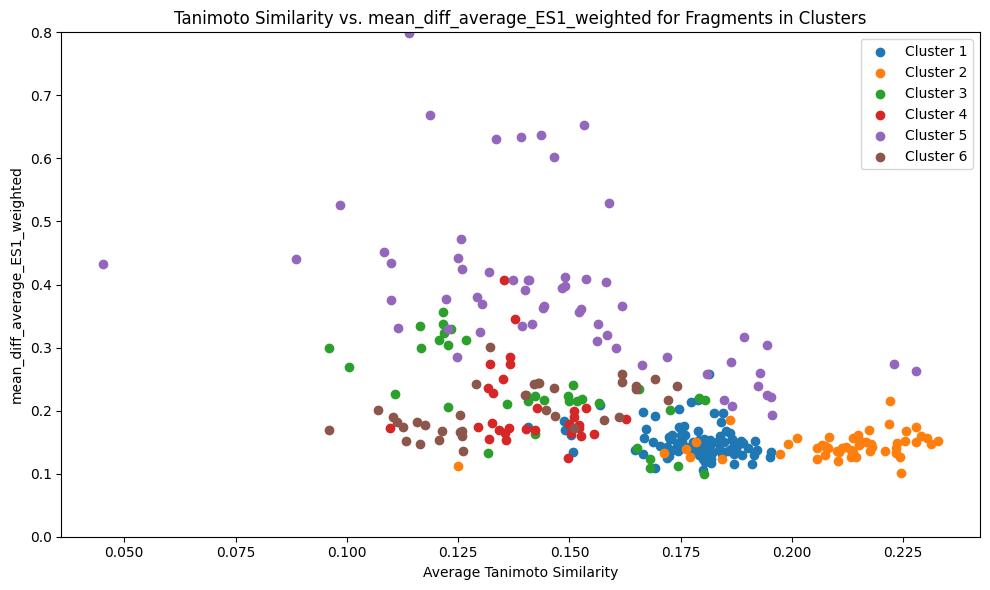

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, AllChem

target = "ES1" 
weight = "_weighted"  

y_lim = 0.8

file_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/fragment_experiment_2/fragment_exp_results.pkl"
morgan_keys = pd.read_pickle(file_path)

# Extract necessary columns
fragments = df_precursors['mol_opt'].values
clusters = morgan_keys['Cluster'].values
mean_diff = morgan_keys[f'mean_diff_average_{target}{weight}'].values

# Calculate Morgan fingerprints for all fragments
morgan_fps = calculate_morgan_fingerprints(fragments)

# Function to calculate Tanimoto similarity
def calculate_tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Calculate Tanimoto similarity matrix
tanimoto_sim = np.zeros((len(fragments), len(fragments)))

for i in range(len(fragments)):
    for j in range(len(fragments)):
        if clusters[i] != clusters[j]:  # Only calculate similarity if fragments are from different clusters
            tanimoto_sim[i, j] = calculate_tanimoto_similarity(morgan_fps[i], morgan_fps[j])

# Create scatterplot
plt.figure(figsize=(10, 6))

for i in range(1, 7):  # Iterate through clusters
    avg_similarity = []
    mean_diff_cluster = []
    for j in range(len(fragments)):
        if clusters[j] == i:  # Consider only fragments from cluster i
            sim_values = tanimoto_sim[j, :]
            sim_values = sim_values[sim_values != 0]  # Exclude zero similarity (same fragment)
            avg_similarity.append(np.mean(sim_values))
            # avg_similarity.append(np.quantile(sim_values, 0.75))
            mean_diff_cluster.append(mean_diff[j])

    plt.scatter(avg_similarity, mean_diff_cluster, label=f'Cluster {i}')

plt.title(f'Tanimoto Similarity vs. mean_diff_average_{target}{weight} for Fragments in Clusters')
plt.xlabel('Average Tanimoto Similarity')
plt.ylabel(f'mean_diff_average_{target}{weight}')
plt.ylim(0, y_lim)
plt.legend()
plt.tight_layout()
plt.show()
